<a href="https://colab.research.google.com/github/githubSivaji/full-stack-book-search/blob/main/FINAL_YEAR_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LOADING THE DATA**

*   First, we load the dataset and normalize the data to a reasonable range.





In [ ]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
import torch as tr


In [ ]:
wine = load_wine()
X, ytrue = wine['data'], tr.tensor(wine['target'])
feature_names = wine['feature_names']
X = MinMaxScaler().fit_transform(X)
X = tr.from_numpy(X)
x

**1.Training the K-Means modeL**

In [ ]:
import torch
from sklearn.cluster import KMeans as KMeans_sk
import numpy

class KMeans(torch.nn.Module):
    def __init__(self, n_clusters, random_state=None):
        super().__init__()
        self.n_clusters = n_clusters
        self.kmeans = KMeans_sk(n_clusters=self.n_clusters, random_state=random_state)

    def fit(self, X):
        if torch.is_tensor(X):
            X = X.numpy()
        self.kmeans.fit(X)
        self.centroids = torch.from_numpy(self.kmeans.cluster_centers_).double()

    def forward(self, x):
        N = x.shape[0]
        distances = torch.cdist(x, self.centroids)**2
        top_val = torch.topk(distances, k=2, dim=1, largest=False).values
        fx = torch.diff(top_val).squeeze()
        return fx

    def decision(self, X):
        distances = torch.cdist(X, self.centroids)**2
        return distances.argmin(-1)

*  ***we train a K-Means model.***



In [ ]:

# random state for reproducibility
m = KMeans(n_clusters=3, random_state=77)
m.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


*  **The cluster assignments and true labels can be visualized in a 2D PCA embedding**.



In [ ]:
import numpy as np
import torch as tr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans as KMeans_sk
cmap = cm.get_cmap('tab20', 20)



<ipython-input-6-26ca69178845>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', 20)


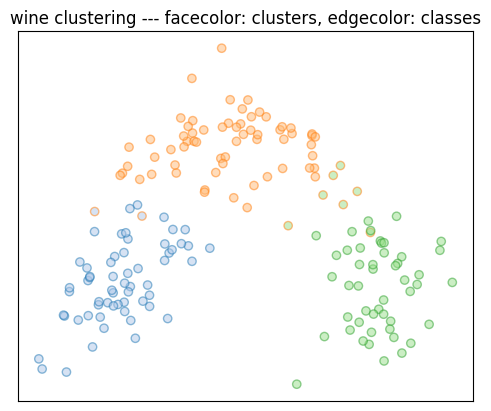

In [ ]:
# find best match between clusters and classes
y = m.decision(X)
C = contingency_matrix(ytrue, y)
_, best_match = linear_sum_assignment(-C.T)
y = tr.tensor([best_match[i] for i in y])

# compute a PCA embedding for visualization
pca = PCA(n_components=2).fit(X)
Z = pca.transform(X)

plt.title('wine clustering --- facecolor: clusters, edgecolor: classes')
plt.scatter(Z[:,0], Z[:,1], facecolor=cmap(2*y.numpy() + 1), edgecolor=cmap(2*ytrue.numpy()), alpha=.5)
plt.gca().set_aspect('equal')
plt.xticks([]), plt.yticks([])
plt.show()

The decision function for a cluster can be recoved as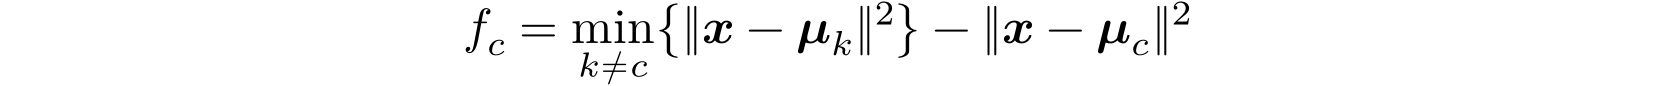

This function contrasts distance to cluster
 against distance to the nearest competitor

In [ ]:
logits = m(X)


As shown in the original paper, the logit can be transformed to a neural network with identical outputs. The layers can be described as
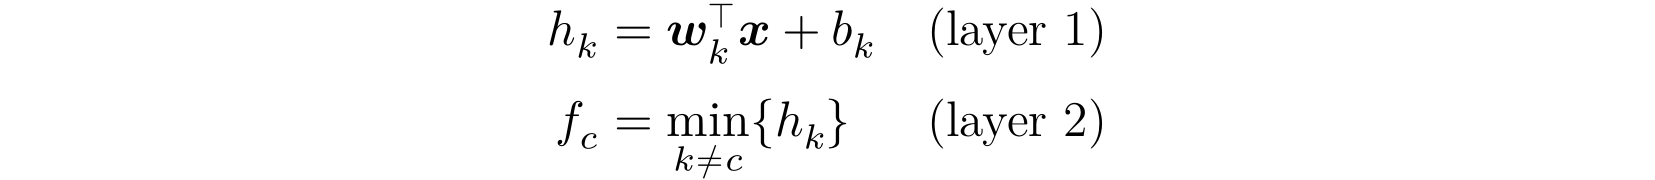

In [ ]:
import torch
import numpy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralizedKMeans(torch.nn.Module):
    def __init__(self, kmeans):
        super().__init__()
        self.n_clusters = kmeans.n_clusters
        self.kmeans = kmeans
        K, D = kmeans.centroids.shape
        self.W = torch.empty(K, K-1, D, dtype=torch.double)
        self.b = torch.empty(K, K-1, dtype=torch.double)
        for c in range(K):
            for kk in range(K-1):
                k = kk if kk < c else kk + 1
                self.W[c, kk] = 2*(kmeans.centroids[c] - kmeans.centroids[k])
                self.b[c, kk] = (torch.norm(kmeans.centroids[k])**2 -
                            torch.norm(kmeans.centroids[c])**2)

    def h(self, X):
        z = torch.einsum('ckd,nd->nck', self.W, X) + self.b
        return z

    def forward(self, X, c=None):
        h = self.h(X)
        out = h.min(-1).values
        if c is None:
            return out.max(-1).values
        else:
            return out[:,c]


In [ ]:
m = NeuralizedKMeans(m)
# check if all outputs are exactly the same with the neuralized model
assert tr.isclose(logits, m(X)).all(), "Predictions are not equal!"

**Explaining the cluster assignment**

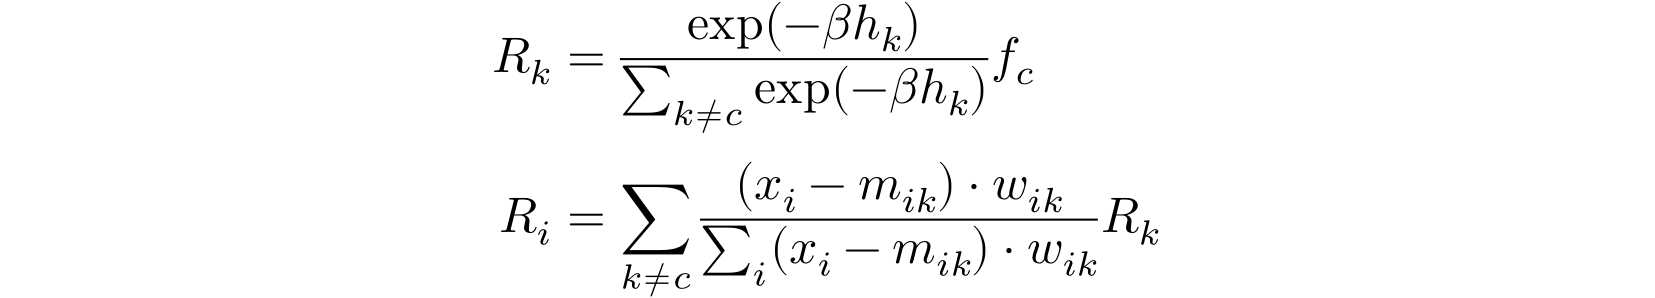


In [ ]:
# soft minpooling layer
def smin(X, s, dim=-1):
    return -(1/s)*torch.logsumexp(-s*X, dim=dim) + (1/s)*numpy.log(X.shape[dim])

# soft maxpooling layer
def smax(X, s, dim=-1):
    return (1/s)*torch.logsumexp(s*X, dim=dim) - (1/s)*numpy.log(X.shape[dim])

def inc(z, eps=1e-9):
    return z + eps*(2*(z >= 0) - 1)

def beta_heuristic(model, X):
    fc = model(X)
    return 1/fc.mean()

def neon(model, X, beta):
    R = torch.zeros_like(X)
    if not torch.is_tensor(beta):
        beta = torch.tensor(beta)
    for i in range(X.shape[0]):
        x = X[[i]]
        ### forward
        h = model.h(x)
        out = h.min(-1).values
        c = out.argmax()
        ### backward
        pk = torch.nn.functional.softmin(beta*h[:,c], dim=-1)
        Rk = out[:,c] * pk
        knc = [k for k in range(model.n_clusters) if k!=c]
        Z = model.W[c]*(x - .5*(model.kmeans.centroids[[c]] + model.kmeans.centroids[knc]))
        Z = Z / inc(Z.sum(-1, keepdims=True))
        R[i] = (Z * Rk.view(-1,1)).sum(0)
    return R

In [ ]:
R = neon(m, X, beta=1)

The explanations can be visualized similarly to the inputs, e.g. in a barplot.

In [ ]:
import numpy as np
import torch as tr

import matplotlib.pyplot as plt

def plot_explanation(x, R, feature_names=None, vlim=None):
    if feature_names is None:
        feature_names = list(range(len(x)))
    else:
        feature_names = [fn.replace('_',' ') for fn in feature_names]
    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.title('data point')
    plt.gca().set_axisbelow(True), plt.grid(linestyle='dashed')
    negative = x.clamp(max=0)
    positive = x.clamp(min=0)
    plt.barh(range(len(feature_names)), negative, color='c')
    plt.barh(range(len(feature_names)), positive, color='m')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.gca().invert_yaxis()
    plt.xlim(0,1.1)

    plt.subplot(122)
    plt.title('feature relevance')
    plt.gca().set_axisbelow(True), plt.grid(linestyle='dashed')
    negative = R.clamp(max=0)
    positive = R.clamp(min=0)
    if vlim is None:
        vlim = max(abs(negative).max(), positive.max()) + .3
    plt.barh(range(len(feature_names)), negative, color='b')
    plt.barh(range(len(feature_names)), positive, color='r')
    plt.xlim(-vlim, vlim)
    plt.yticks(range(len(feature_names)),[]*len(feature_names))
    plt.gca().invert_yaxis()

Cluster Explanations for truly classify data

data point 0
  cluster assignment: 0 (probability 0.69)
  true class        : 0
  sum(R) / logit    : 0.8049 / 0.8049


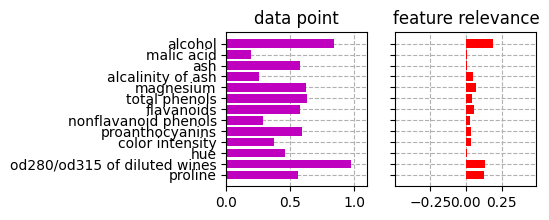

--------------------------------------------------------------------------------
data point 1
  cluster assignment: 0 (probability 0.59)
  true class        : 0
  sum(R) / logit    : 0.3552 / 0.3552


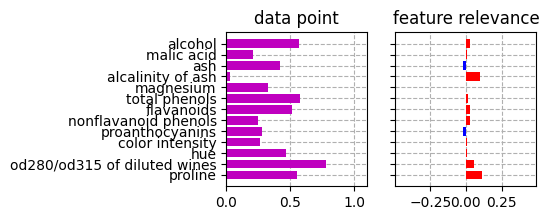

--------------------------------------------------------------------------------
data point 2
  cluster assignment: 0 (probability 0.63)
  true class        : 0
  sum(R) / logit    : 0.5258 / 0.5258


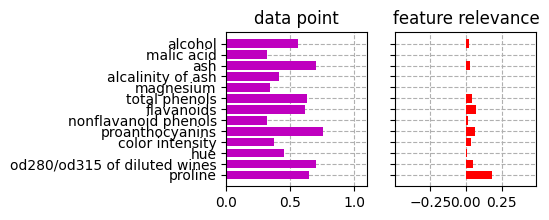

--------------------------------------------------------------------------------
data point 3
  cluster assignment: 0 (probability 0.78)
  true class        : 0
  sum(R) / logit    : 1.2534 / 1.2534


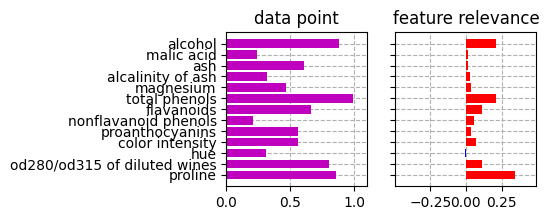

--------------------------------------------------------------------------------
data point 4
  cluster assignment: 0 (probability 0.53)
  true class        : 0
  sum(R) / logit    : 0.1147 / 0.1147


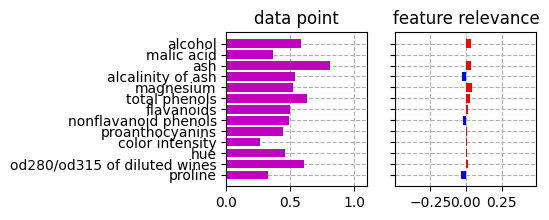

--------------------------------------------------------------------------------
data point 5
  cluster assignment: 0 (probability 0.73)
  true class        : 0
  sum(R) / logit    : 0.9987 / 0.9987


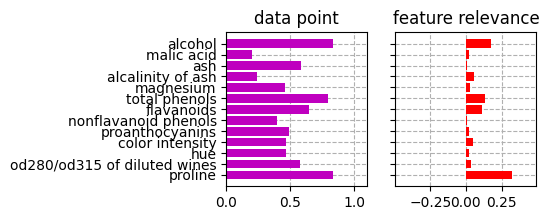

--------------------------------------------------------------------------------
data point 6
  cluster assignment: 0 (probability 0.68)
  true class        : 0
  sum(R) / logit    : 0.7463 / 0.7463


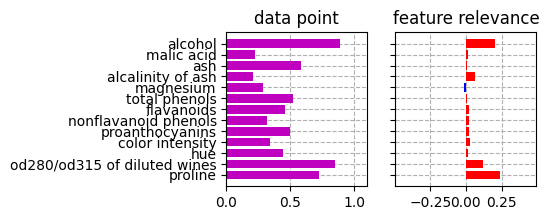

--------------------------------------------------------------------------------
data point 7
  cluster assignment: 0 (probability 0.67)
  true class        : 0
  sum(R) / logit    : 0.7064 / 0.7064


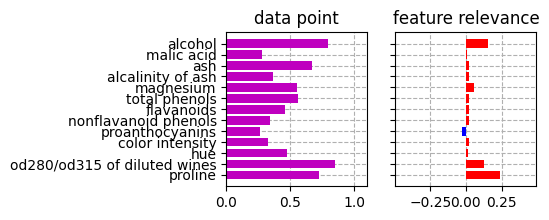

--------------------------------------------------------------------------------
data point 8
  cluster assignment: 0 (probability 0.66)
  true class        : 0
  sum(R) / logit    : 0.6844 / 0.6844


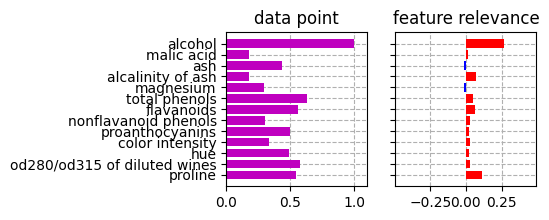

--------------------------------------------------------------------------------
data point 9
  cluster assignment: 0 (probability 0.66)
  true class        : 0
  sum(R) / logit    : 0.6470 / 0.6470


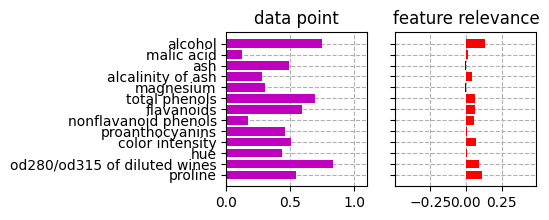

--------------------------------------------------------------------------------
data point 10
  cluster assignment: 0 (probability 0.72)
  true class        : 0
  sum(R) / logit    : 0.9436 / 0.9436


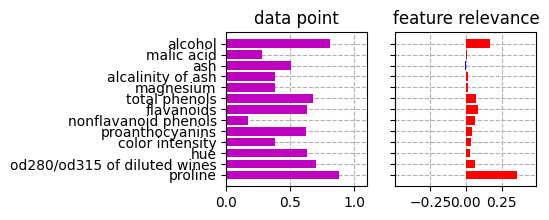

--------------------------------------------------------------------------------
data point 11
  cluster assignment: 0 (probability 0.63)
  true class        : 0
  sum(R) / logit    : 0.5141 / 0.5141


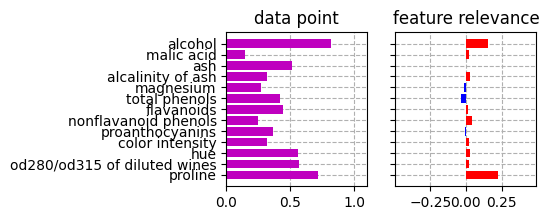

--------------------------------------------------------------------------------
data point 12
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5684 / 0.5684


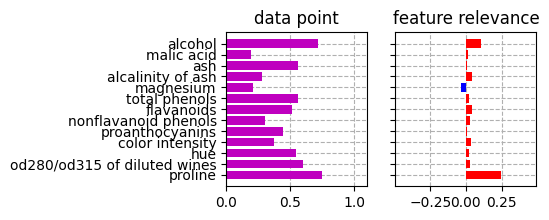

--------------------------------------------------------------------------------
data point 13
  cluster assignment: 0 (probability 0.70)
  true class        : 0
  sum(R) / logit    : 0.8535 / 0.8535


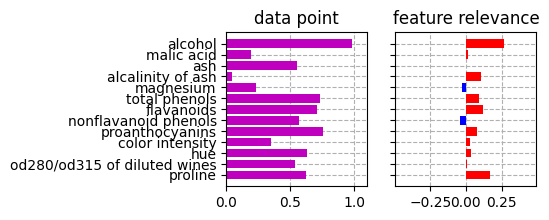

--------------------------------------------------------------------------------
data point 14
  cluster assignment: 0 (probability 0.77)
  true class        : 0
  sum(R) / logit    : 1.2363 / 1.2363


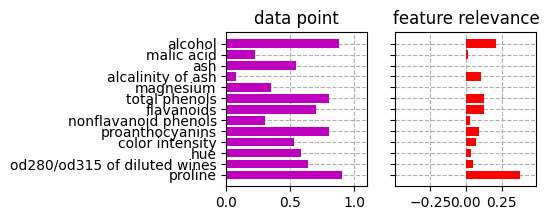

--------------------------------------------------------------------------------
data point 15
  cluster assignment: 0 (probability 0.67)
  true class        : 0
  sum(R) / logit    : 0.7159 / 0.7159


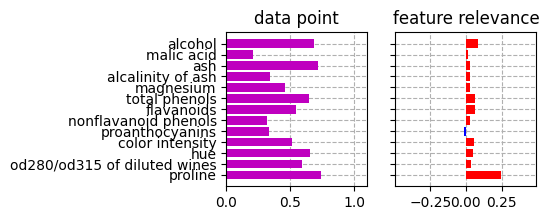

--------------------------------------------------------------------------------
data point 16
  cluster assignment: 0 (probability 0.69)
  true class        : 0
  sum(R) / logit    : 0.7884 / 0.7884


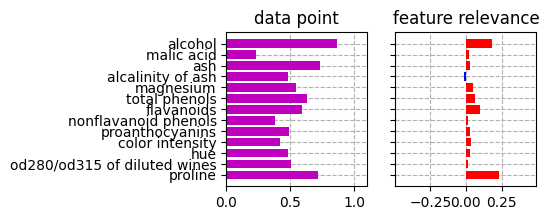

--------------------------------------------------------------------------------
data point 17
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5710 / 0.5710


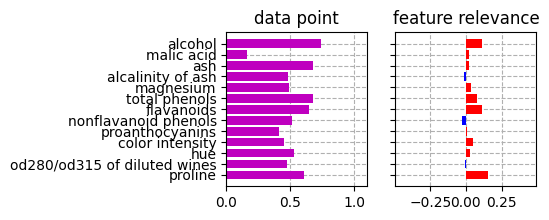

--------------------------------------------------------------------------------
data point 18
  cluster assignment: 0 (probability 0.77)
  true class        : 0
  sum(R) / logit    : 1.2221 / 1.2221


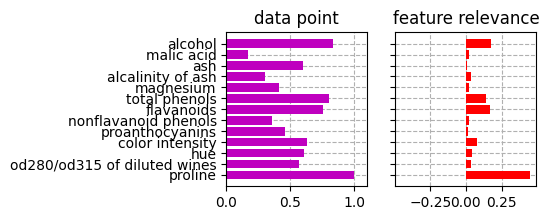

--------------------------------------------------------------------------------
data point 19
  cluster assignment: 0 (probability 0.62)
  true class        : 0
  sum(R) / logit    : 0.4725 / 0.4725


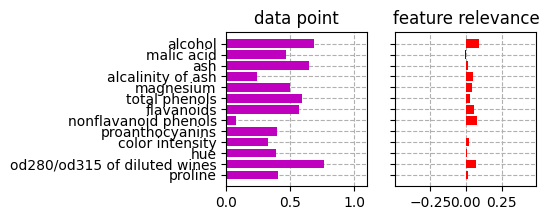

--------------------------------------------------------------------------------
data point 20
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5899 / 0.5899


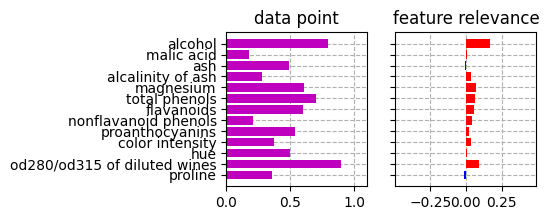

--------------------------------------------------------------------------------
data point 21
  cluster assignment: 0 (probability 0.52)
  true class        : 0
  sum(R) / logit    : 0.0790 / 0.0790


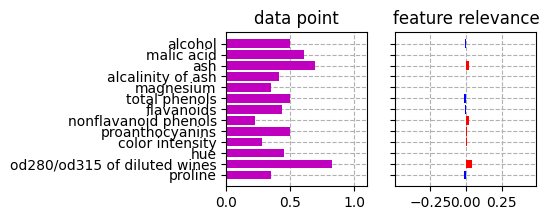

--------------------------------------------------------------------------------
data point 22
  cluster assignment: 0 (probability 0.61)
  true class        : 0
  sum(R) / logit    : 0.4398 / 0.4398


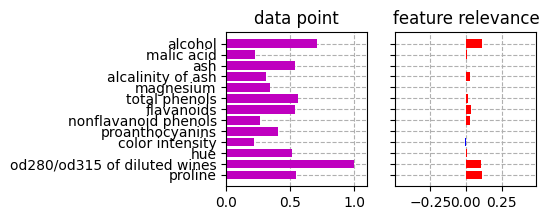

--------------------------------------------------------------------------------
data point 23
  cluster assignment: 0 (probability 0.54)
  true class        : 0
  sum(R) / logit    : 0.1419 / 0.1419


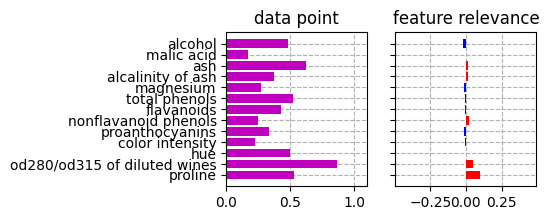

--------------------------------------------------------------------------------
data point 24
  cluster assignment: 0 (probability 0.54)
  true class        : 0
  sum(R) / logit    : 0.1762 / 0.1762


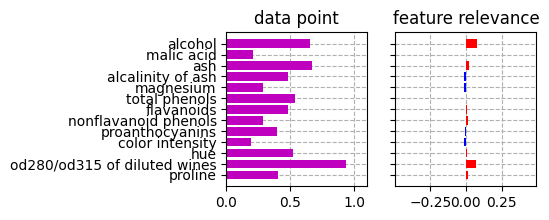

--------------------------------------------------------------------------------
data point 25
  cluster assignment: 0 (probability 0.52)
  true class        : 0
  sum(R) / logit    : 0.0741 / 0.0741


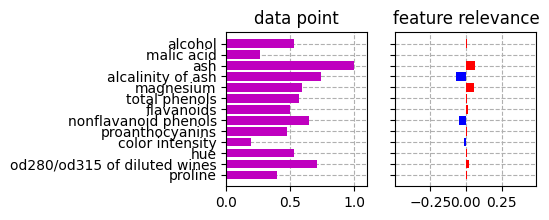

--------------------------------------------------------------------------------
data point 26
  cluster assignment: 0 (probability 0.61)
  true class        : 0
  sum(R) / logit    : 0.4539 / 0.4539


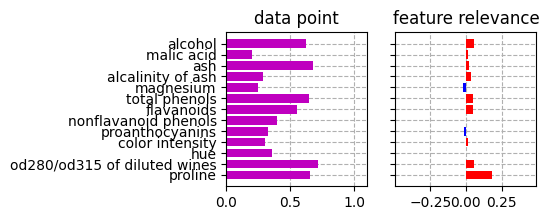

--------------------------------------------------------------------------------
data point 27
  cluster assignment: 0 (probability 0.57)
  true class        : 0
  sum(R) / logit    : 0.2712 / 0.2712


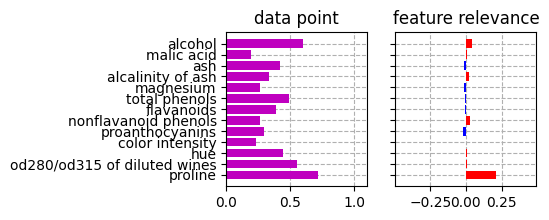

--------------------------------------------------------------------------------
data point 28
  cluster assignment: 0 (probability 0.60)
  true class        : 0
  sum(R) / logit    : 0.4209 / 0.4209


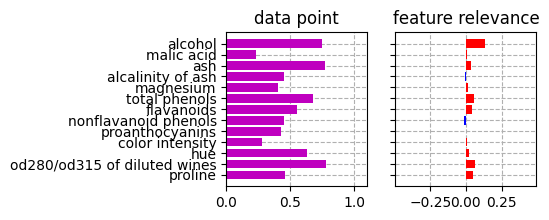

--------------------------------------------------------------------------------
data point 29
  cluster assignment: 0 (probability 0.61)
  true class        : 0
  sum(R) / logit    : 0.4622 / 0.4622


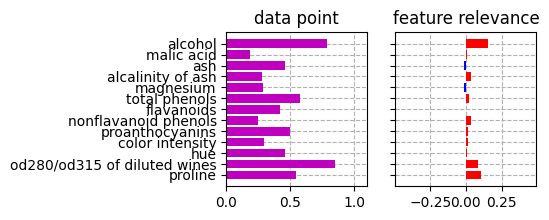

--------------------------------------------------------------------------------
data point 30
  cluster assignment: 0 (probability 0.65)
  true class        : 0
  sum(R) / logit    : 0.6206 / 0.6206


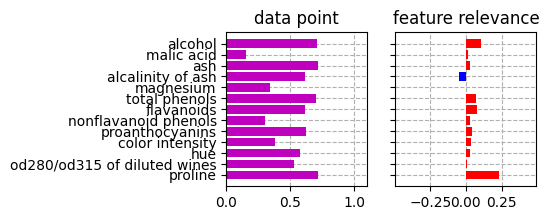

--------------------------------------------------------------------------------
data point 31
  cluster assignment: 0 (probability 0.69)
  true class        : 0
  sum(R) / logit    : 0.8049 / 0.8049


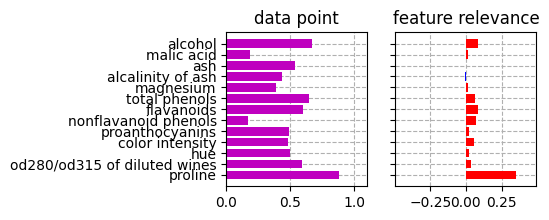

--------------------------------------------------------------------------------
data point 32
  cluster assignment: 0 (probability 0.56)
  true class        : 0
  sum(R) / logit    : 0.2371 / 0.2371


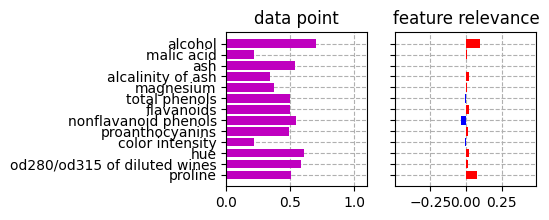

--------------------------------------------------------------------------------
data point 33
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5813 / 0.5813


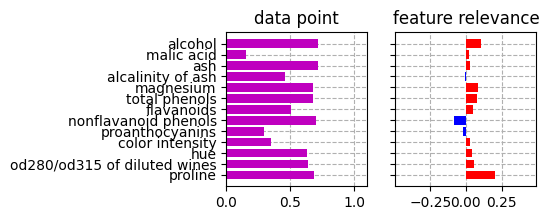

--------------------------------------------------------------------------------
data point 34
  cluster assignment: 0 (probability 0.58)
  true class        : 0
  sum(R) / logit    : 0.3185 / 0.3185


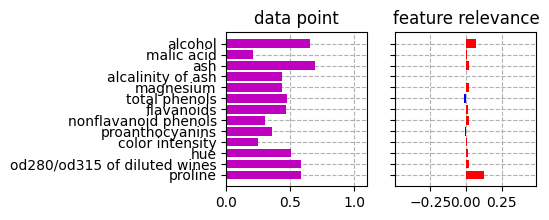

--------------------------------------------------------------------------------
data point 35
  cluster assignment: 0 (probability 0.57)
  true class        : 0
  sum(R) / logit    : 0.2980 / 0.2980


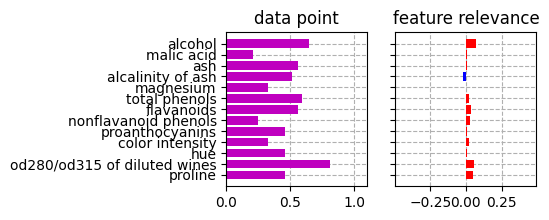

--------------------------------------------------------------------------------
data point 36
  cluster assignment: 0 (probability 0.56)
  true class        : 0
  sum(R) / logit    : 0.2355 / 0.2355


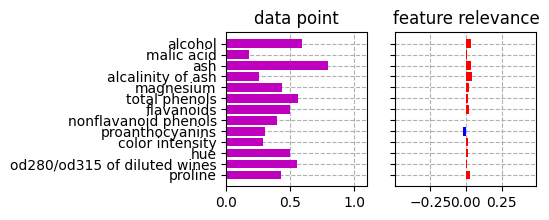

--------------------------------------------------------------------------------
data point 37
  cluster assignment: 0 (probability 0.54)
  true class        : 0
  sum(R) / logit    : 0.1660 / 0.1660


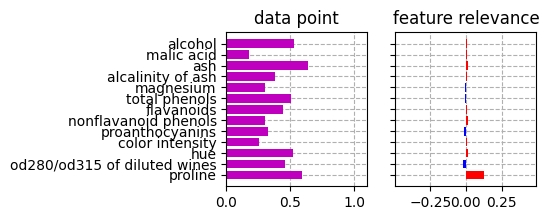

--------------------------------------------------------------------------------
data point 38
  cluster assignment: 0 (probability 0.53)
  true class        : 0
  sum(R) / logit    : 0.1063 / 0.1063


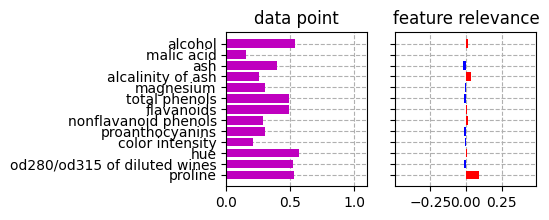

--------------------------------------------------------------------------------
data point 39
  cluster assignment: 0 (probability 0.66)
  true class        : 0
  sum(R) / logit    : 0.6730 / 0.6730


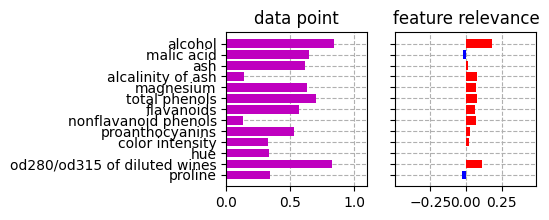

--------------------------------------------------------------------------------
data point 40
  cluster assignment: 0 (probability 0.61)
  true class        : 0
  sum(R) / logit    : 0.4542 / 0.4542


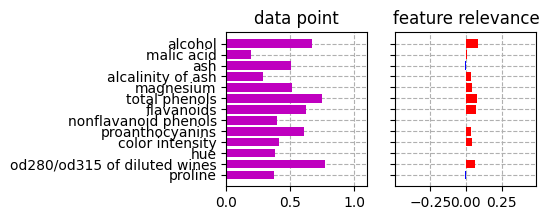

--------------------------------------------------------------------------------
data point 41
  cluster assignment: 0 (probability 0.54)
  true class        : 0
  sum(R) / logit    : 0.1789 / 0.1789


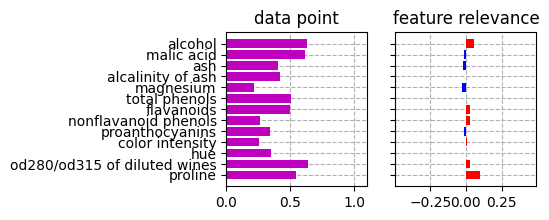

--------------------------------------------------------------------------------
data point 42
  cluster assignment: 0 (probability 0.68)
  true class        : 0
  sum(R) / logit    : 0.7647 / 0.7647


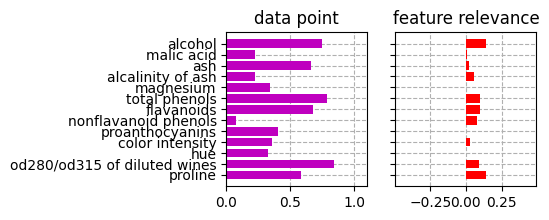

--------------------------------------------------------------------------------
data point 43
  cluster assignment: 0 (probability 0.51)
  true class        : 0
  sum(R) / logit    : 0.0214 / 0.0214


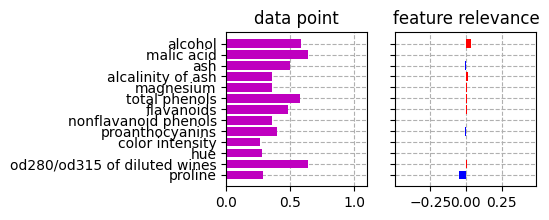

--------------------------------------------------------------------------------
data point 44
  cluster assignment: 0 (probability 0.56)
  true class        : 0
  sum(R) / logit    : 0.2591 / 0.2591


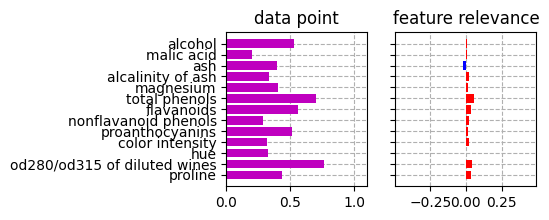

--------------------------------------------------------------------------------
data point 45
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5691 / 0.5691


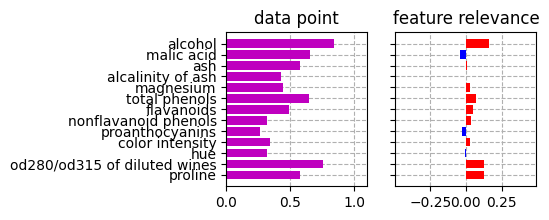

--------------------------------------------------------------------------------
data point 46
  cluster assignment: 0 (probability 0.68)
  true class        : 0
  sum(R) / logit    : 0.7356 / 0.7356


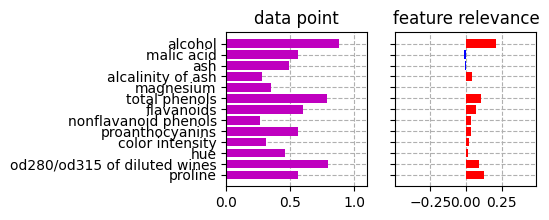

--------------------------------------------------------------------------------
data point 47
  cluster assignment: 0 (probability 0.65)
  true class        : 0
  sum(R) / logit    : 0.6072 / 0.6072


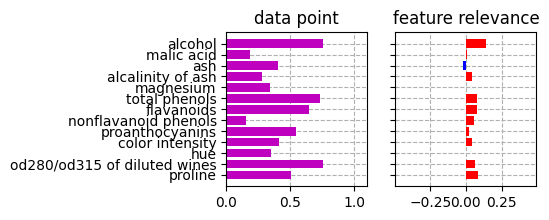

--------------------------------------------------------------------------------
data point 48
  cluster assignment: 0 (probability 0.63)
  true class        : 0
  sum(R) / logit    : 0.5405 / 0.5405


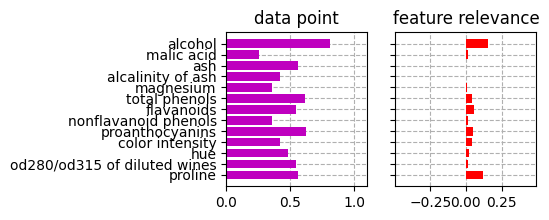

--------------------------------------------------------------------------------
data point 49
  cluster assignment: 0 (probability 0.70)
  true class        : 0
  sum(R) / logit    : 0.8243 / 0.8243


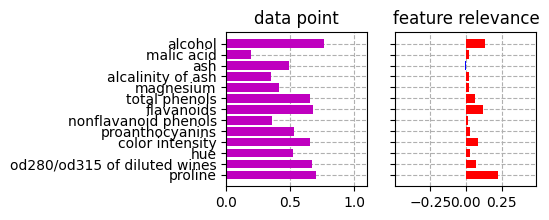

--------------------------------------------------------------------------------
data point 50
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5569 / 0.5569


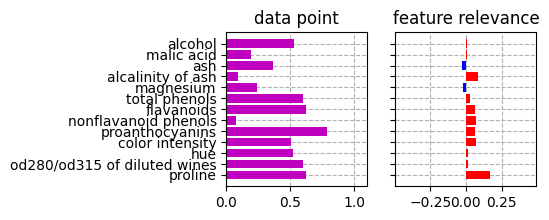

--------------------------------------------------------------------------------
data point 51
  cluster assignment: 0 (probability 0.66)
  true class        : 0
  sum(R) / logit    : 0.6579 / 0.6579


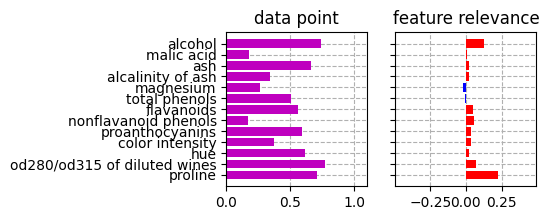

--------------------------------------------------------------------------------
data point 52
  cluster assignment: 0 (probability 0.71)
  true class        : 0
  sum(R) / logit    : 0.9188 / 0.9188


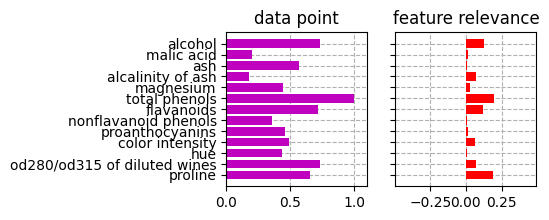

--------------------------------------------------------------------------------
data point 53
  cluster assignment: 0 (probability 0.68)
  true class        : 0
  sum(R) / logit    : 0.7471 / 0.7471


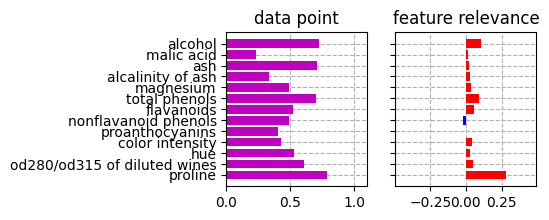

--------------------------------------------------------------------------------
data point 54
  cluster assignment: 0 (probability 0.63)
  true class        : 0
  sum(R) / logit    : 0.5448 / 0.5448


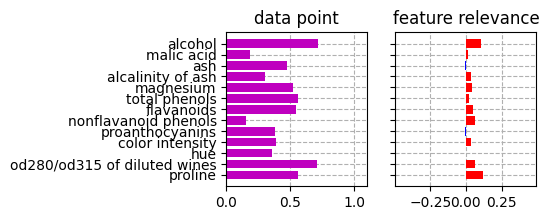

--------------------------------------------------------------------------------
data point 55
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5837 / 0.5837


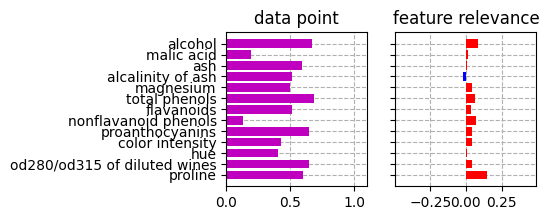

--------------------------------------------------------------------------------
data point 56
  cluster assignment: 0 (probability 0.67)
  true class        : 0
  sum(R) / logit    : 0.7081 / 0.7081


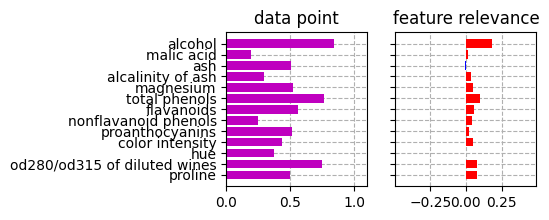

--------------------------------------------------------------------------------
data point 57
  cluster assignment: 0 (probability 0.64)
  true class        : 0
  sum(R) / logit    : 0.5879 / 0.5879


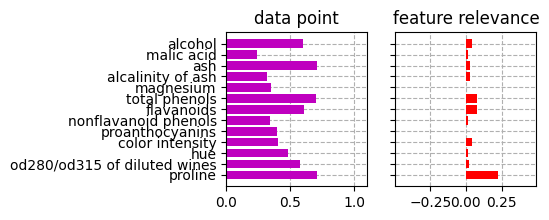

--------------------------------------------------------------------------------
data point 58
  cluster assignment: 0 (probability 0.70)
  true class        : 0
  sum(R) / logit    : 0.8684 / 0.8684


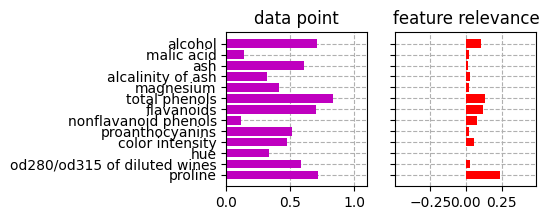

--------------------------------------------------------------------------------
data point 59
  cluster assignment: 1 (probability 0.58)
  true class        : 1
  sum(R) / logit    : 0.3139 / 0.3139


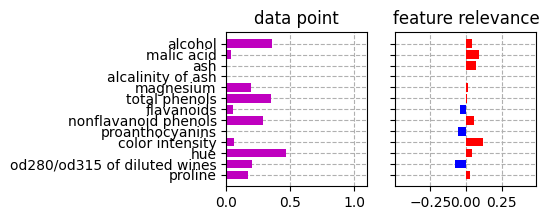

--------------------------------------------------------------------------------
data point 62
  cluster assignment: 1 (probability 0.56)
  true class        : 1
  sum(R) / logit    : 0.2527 / 0.2527


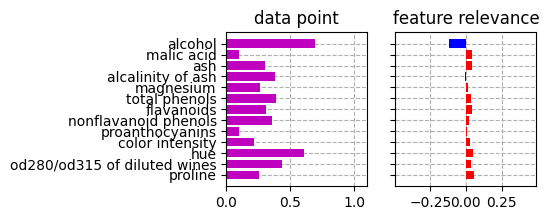

--------------------------------------------------------------------------------
data point 63
  cluster assignment: 1 (probability 0.56)
  true class        : 1
  sum(R) / logit    : 0.2229 / 0.2229


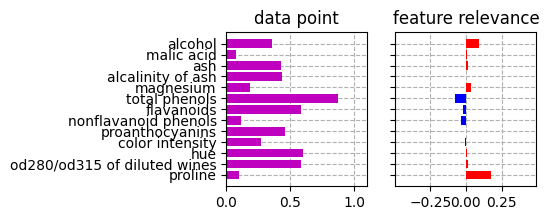

--------------------------------------------------------------------------------
data point 64
  cluster assignment: 1 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4574 / 0.4574


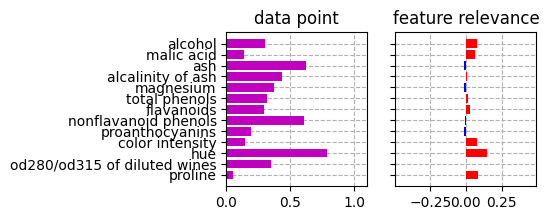

--------------------------------------------------------------------------------
data point 65
  cluster assignment: 1 (probability 0.56)
  true class        : 1
  sum(R) / logit    : 0.2360 / 0.2360


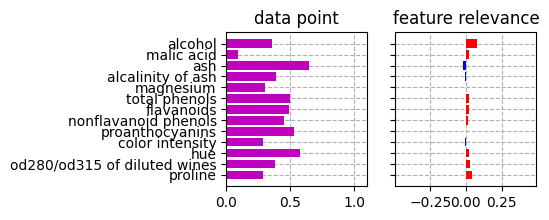

--------------------------------------------------------------------------------
data point 66
  cluster assignment: 1 (probability 0.51)
  true class        : 1
  sum(R) / logit    : 0.0599 / 0.0599


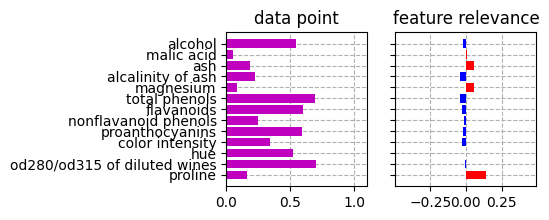

--------------------------------------------------------------------------------
data point 67
  cluster assignment: 1 (probability 0.63)
  true class        : 1
  sum(R) / logit    : 0.5206 / 0.5206


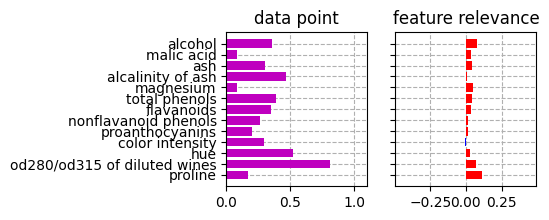

--------------------------------------------------------------------------------
data point 69
  cluster assignment: 1 (probability 0.55)
  true class        : 1
  sum(R) / logit    : 0.1929 / 0.1929


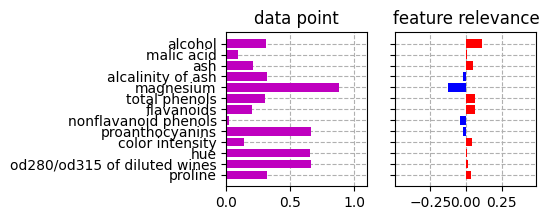

--------------------------------------------------------------------------------
data point 71
  cluster assignment: 1 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0698 / 0.0698


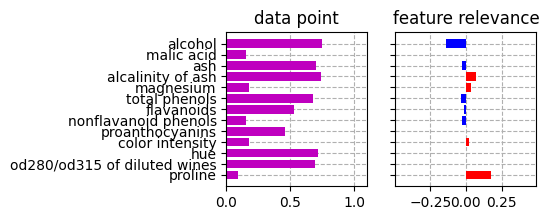

--------------------------------------------------------------------------------
data point 72
  cluster assignment: 1 (probability 0.59)
  true class        : 1
  sum(R) / logit    : 0.3530 / 0.3530


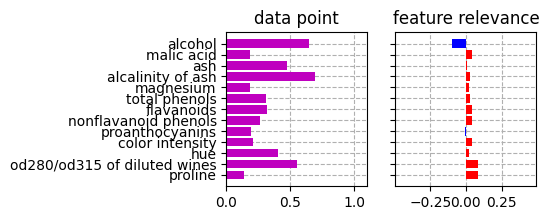

--------------------------------------------------------------------------------
data point 74
  cluster assignment: 1 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0805 / 0.0805


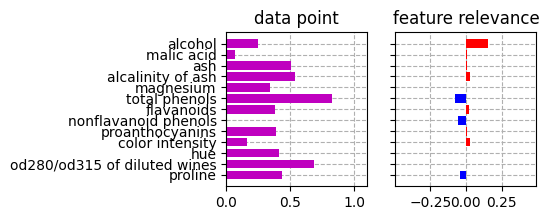

--------------------------------------------------------------------------------
data point 75
  cluster assignment: 1 (probability 0.60)
  true class        : 1
  sum(R) / logit    : 0.4082 / 0.4082


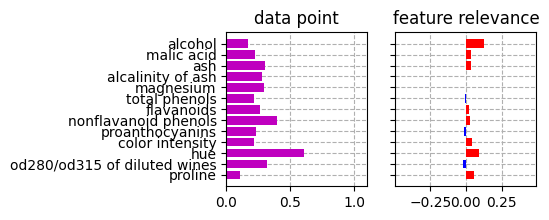

--------------------------------------------------------------------------------
data point 76
  cluster assignment: 1 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4592 / 0.4592


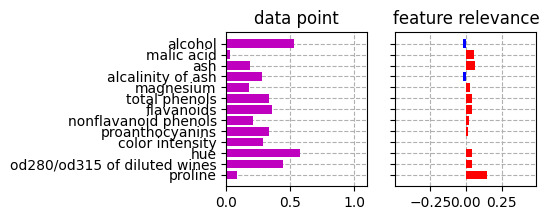

--------------------------------------------------------------------------------
data point 77
  cluster assignment: 1 (probability 0.54)
  true class        : 1
  sum(R) / logit    : 0.1794 / 0.1794


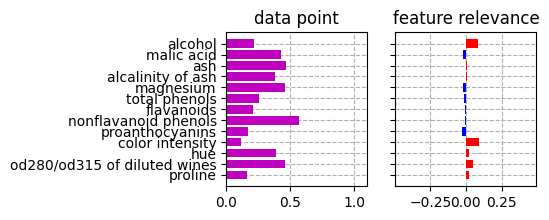

--------------------------------------------------------------------------------
data point 78
  cluster assignment: 1 (probability 0.55)
  true class        : 1
  sum(R) / logit    : 0.2119 / 0.2119


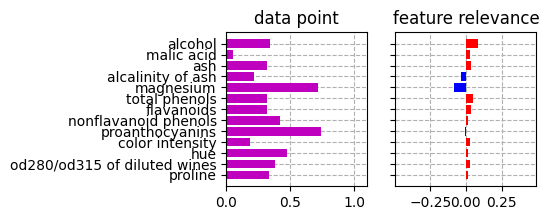

--------------------------------------------------------------------------------
data point 79
  cluster assignment: 1 (probability 0.59)
  true class        : 1
  sum(R) / logit    : 0.3725 / 0.3725


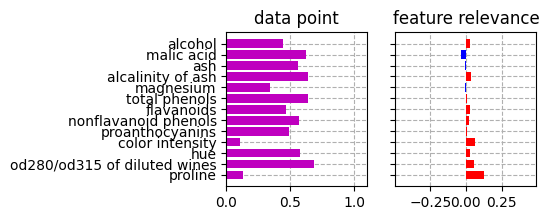

--------------------------------------------------------------------------------
data point 80
  cluster assignment: 1 (probability 0.68)
  true class        : 1
  sum(R) / logit    : 0.7316 / 0.7316


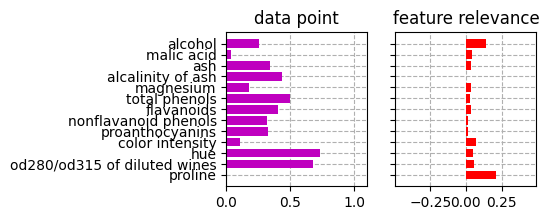

--------------------------------------------------------------------------------
data point 81
  cluster assignment: 1 (probability 0.55)
  true class        : 1
  sum(R) / logit    : 0.2044 / 0.2044


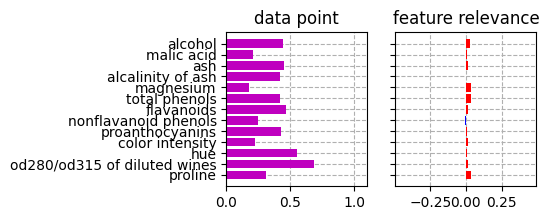

--------------------------------------------------------------------------------
data point 82
  cluster assignment: 1 (probability 0.67)
  true class        : 1
  sum(R) / logit    : 0.6885 / 0.6885


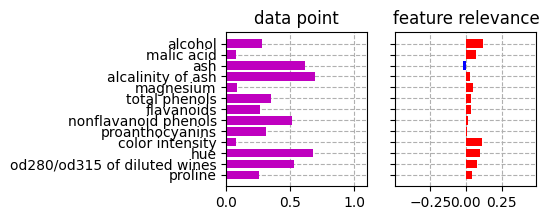

--------------------------------------------------------------------------------
data point 84
  cluster assignment: 1 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4400 / 0.4400


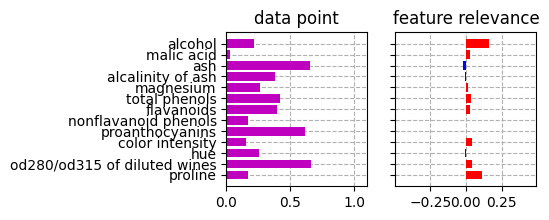

--------------------------------------------------------------------------------
data point 85
  cluster assignment: 1 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4384 / 0.4384


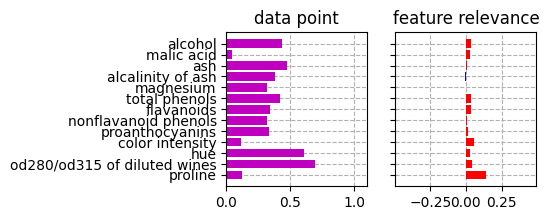

--------------------------------------------------------------------------------
data point 86
  cluster assignment: 1 (probability 0.62)
  true class        : 1
  sum(R) / logit    : 0.4826 / 0.4826


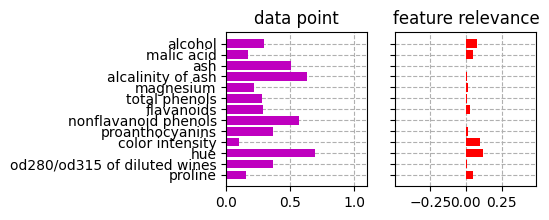

--------------------------------------------------------------------------------
data point 87
  cluster assignment: 1 (probability 0.69)
  true class        : 1
  sum(R) / logit    : 0.8034 / 0.8034


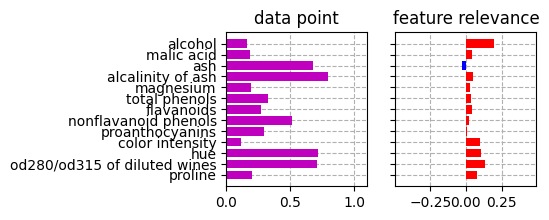

--------------------------------------------------------------------------------
data point 88
  cluster assignment: 1 (probability 0.60)
  true class        : 1
  sum(R) / logit    : 0.4245 / 0.4245


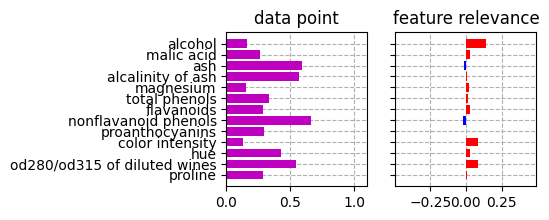

--------------------------------------------------------------------------------
data point 89
  cluster assignment: 1 (probability 0.68)
  true class        : 1
  sum(R) / logit    : 0.7438 / 0.7438


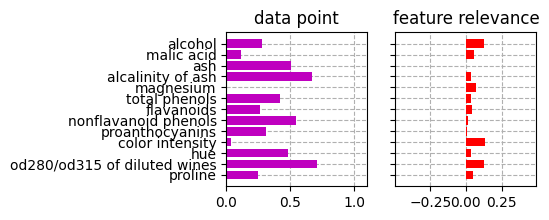

--------------------------------------------------------------------------------
data point 90
  cluster assignment: 1 (probability 0.57)
  true class        : 1
  sum(R) / logit    : 0.2841 / 0.2841


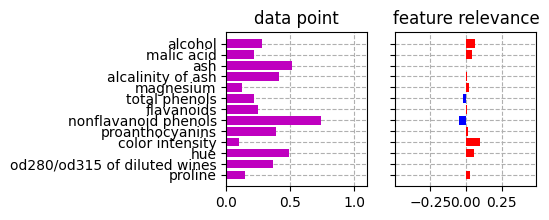

--------------------------------------------------------------------------------
data point 91
  cluster assignment: 1 (probability 0.57)
  true class        : 1
  sum(R) / logit    : 0.2991 / 0.2991


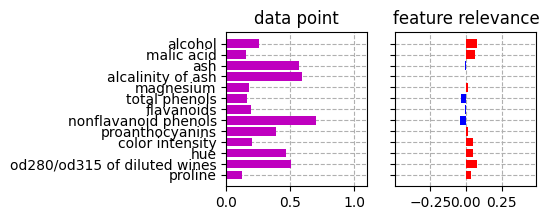

--------------------------------------------------------------------------------
data point 93
  cluster assignment: 1 (probability 0.64)
  true class        : 1
  sum(R) / logit    : 0.5540 / 0.5540


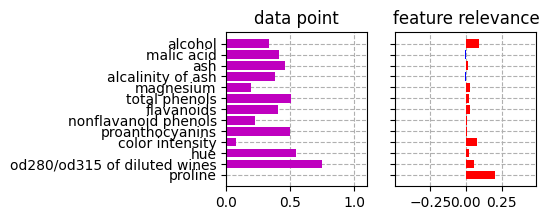

--------------------------------------------------------------------------------
data point 94
  cluster assignment: 1 (probability 0.63)
  true class        : 1
  sum(R) / logit    : 0.5297 / 0.5297


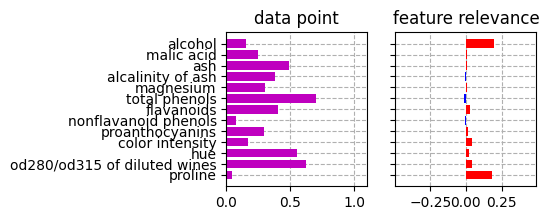

--------------------------------------------------------------------------------
data point 96
  cluster assignment: 1 (probability 0.58)
  true class        : 1
  sum(R) / logit    : 0.3068 / 0.3068


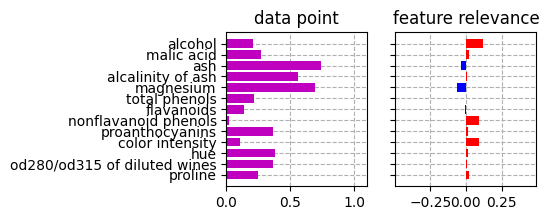

--------------------------------------------------------------------------------
data point 97
  cluster assignment: 1 (probability 0.62)
  true class        : 1
  sum(R) / logit    : 0.4928 / 0.4928


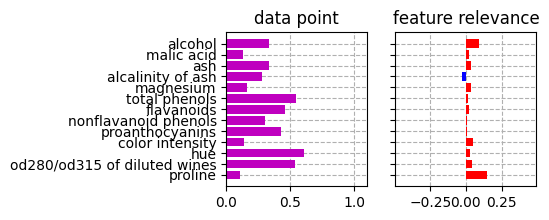

--------------------------------------------------------------------------------
data point 98
  cluster assignment: 1 (probability 0.51)
  true class        : 1
  sum(R) / logit    : 0.0430 / 0.0430


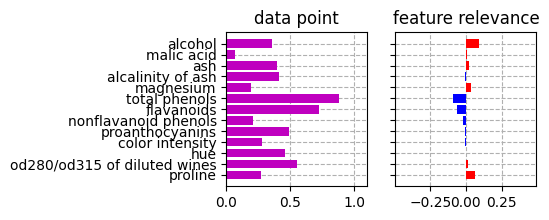

--------------------------------------------------------------------------------
data point 99
  cluster assignment: 1 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4458 / 0.4458


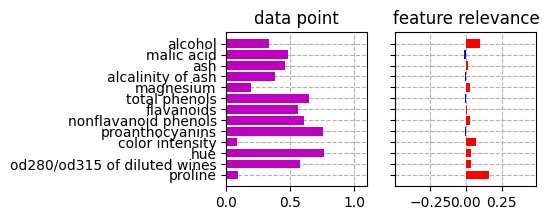

--------------------------------------------------------------------------------
data point 100
  cluster assignment: 1 (probability 0.60)
  true class        : 1
  sum(R) / logit    : 0.4133 / 0.4133


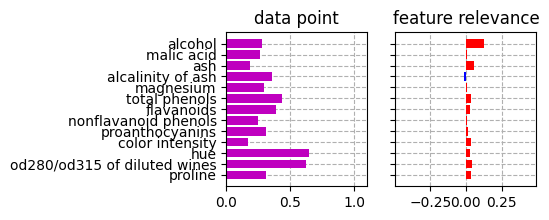

--------------------------------------------------------------------------------
data point 101
  cluster assignment: 1 (probability 0.63)
  true class        : 1
  sum(R) / logit    : 0.5322 / 0.5322


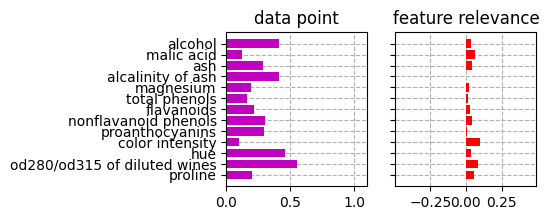

--------------------------------------------------------------------------------
data point 102
  cluster assignment: 1 (probability 0.62)
  true class        : 1
  sum(R) / logit    : 0.4783 / 0.4783


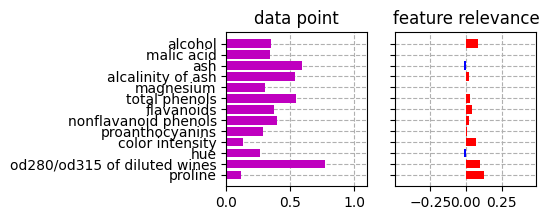

--------------------------------------------------------------------------------
data point 103
  cluster assignment: 1 (probability 0.65)
  true class        : 1
  sum(R) / logit    : 0.6130 / 0.6130


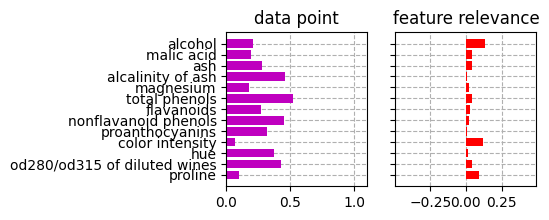

--------------------------------------------------------------------------------
data point 104
  cluster assignment: 1 (probability 0.60)
  true class        : 1
  sum(R) / logit    : 0.4188 / 0.4188


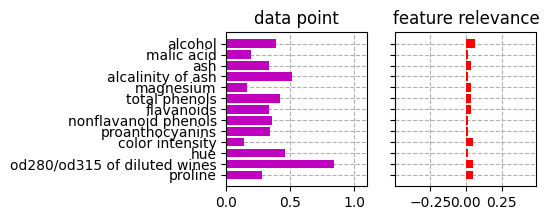

--------------------------------------------------------------------------------
data point 105
  cluster assignment: 1 (probability 0.57)
  true class        : 1
  sum(R) / logit    : 0.2970 / 0.2970


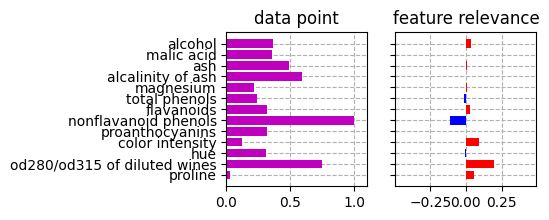

--------------------------------------------------------------------------------
data point 106
  cluster assignment: 1 (probability 0.66)
  true class        : 1
  sum(R) / logit    : 0.6417 / 0.6417


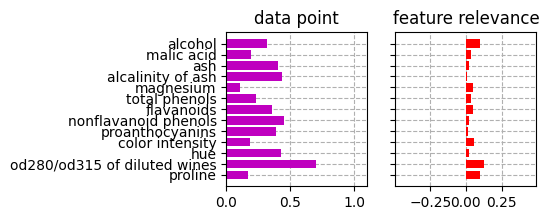

--------------------------------------------------------------------------------
data point 107
  cluster assignment: 1 (probability 0.53)
  true class        : 1
  sum(R) / logit    : 0.1288 / 0.1288


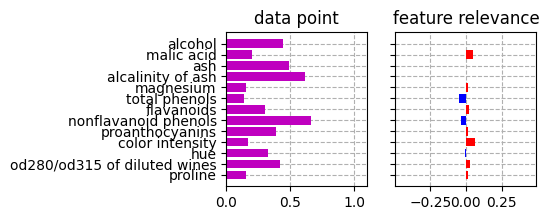

--------------------------------------------------------------------------------
data point 108
  cluster assignment: 1 (probability 0.66)
  true class        : 1
  sum(R) / logit    : 0.6819 / 0.6819


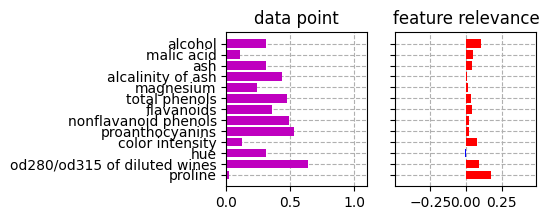

--------------------------------------------------------------------------------
data point 109
  cluster assignment: 1 (probability 0.58)
  true class        : 1
  sum(R) / logit    : 0.3035 / 0.3035


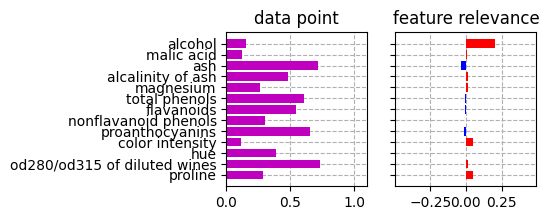

--------------------------------------------------------------------------------
data point 110
  cluster assignment: 1 (probability 0.59)
  true class        : 1
  sum(R) / logit    : 0.3661 / 0.3661


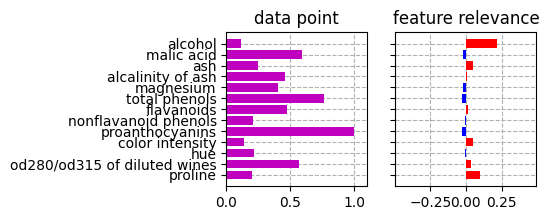

--------------------------------------------------------------------------------
data point 111
  cluster assignment: 1 (probability 0.65)
  true class        : 1
  sum(R) / logit    : 0.6145 / 0.6145


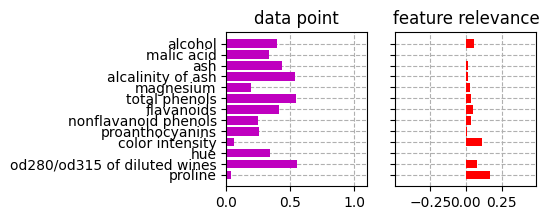

--------------------------------------------------------------------------------
data point 112
  cluster assignment: 1 (probability 0.54)
  true class        : 1
  sum(R) / logit    : 0.1517 / 0.1517


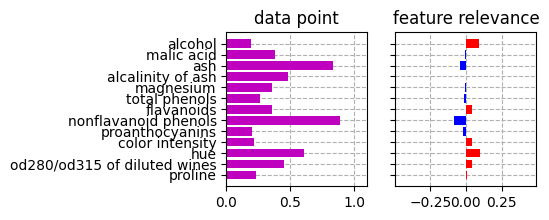

--------------------------------------------------------------------------------
data point 113
  cluster assignment: 1 (probability 0.66)
  true class        : 1
  sum(R) / logit    : 0.6652 / 0.6652


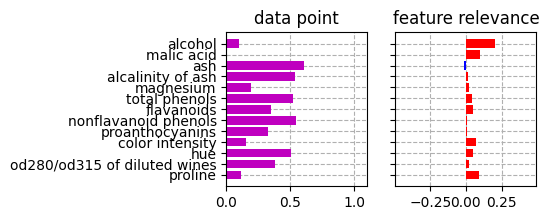

--------------------------------------------------------------------------------
data point 114
  cluster assignment: 1 (probability 0.67)
  true class        : 1
  sum(R) / logit    : 0.6870 / 0.6870


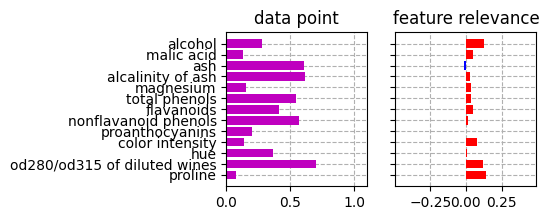

--------------------------------------------------------------------------------
data point 115
  cluster assignment: 1 (probability 0.73)
  true class        : 1
  sum(R) / logit    : 0.9715 / 0.9715


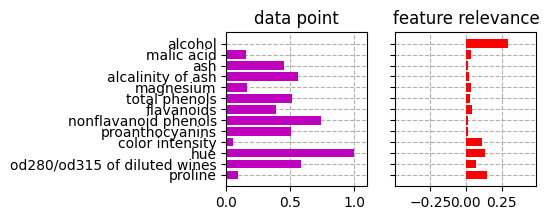

--------------------------------------------------------------------------------
data point 116
  cluster assignment: 1 (probability 0.68)
  true class        : 1
  sum(R) / logit    : 0.7683 / 0.7683


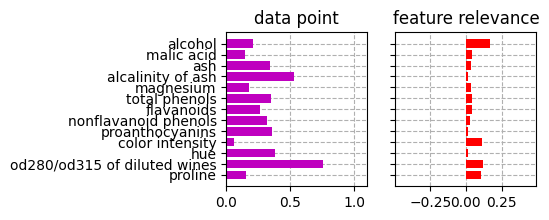

--------------------------------------------------------------------------------
data point 117
  cluster assignment: 1 (probability 0.66)
  true class        : 1
  sum(R) / logit    : 0.6595 / 0.6595


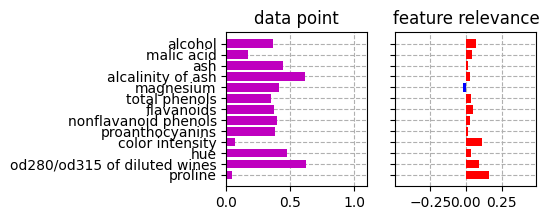

--------------------------------------------------------------------------------
data point 119
  cluster assignment: 1 (probability 0.65)
  true class        : 1
  sum(R) / logit    : 0.6052 / 0.6052


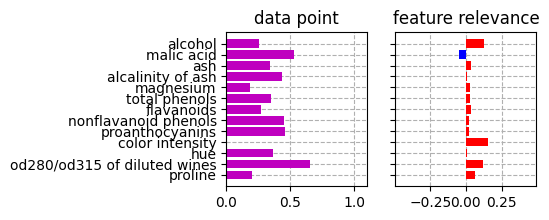

--------------------------------------------------------------------------------
data point 120
  cluster assignment: 1 (probability 0.60)
  true class        : 1
  sum(R) / logit    : 0.3973 / 0.3973


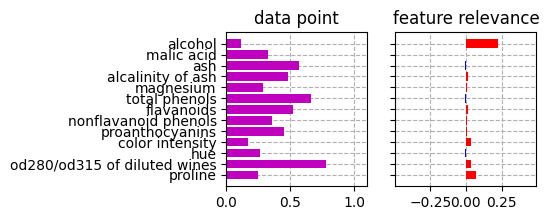

--------------------------------------------------------------------------------
data point 121
  cluster assignment: 1 (probability 0.54)
  true class        : 1
  sum(R) / logit    : 0.1711 / 0.1711


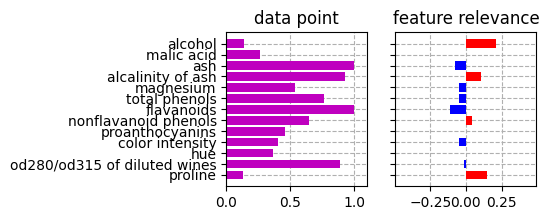

--------------------------------------------------------------------------------
data point 122
  cluster assignment: 1 (probability 0.59)
  true class        : 1
  sum(R) / logit    : 0.3588 / 0.3588


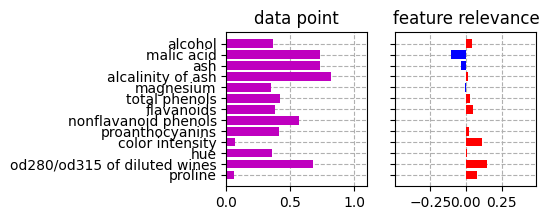

--------------------------------------------------------------------------------
data point 123
  cluster assignment: 1 (probability 0.59)
  true class        : 1
  sum(R) / logit    : 0.3712 / 0.3712


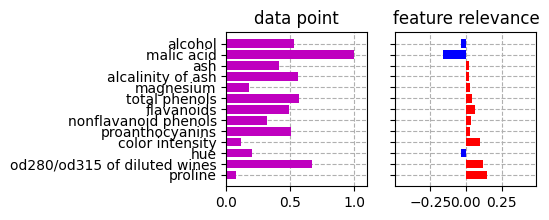

--------------------------------------------------------------------------------
data point 124
  cluster assignment: 1 (probability 0.60)
  true class        : 1
  sum(R) / logit    : 0.4084 / 0.4084


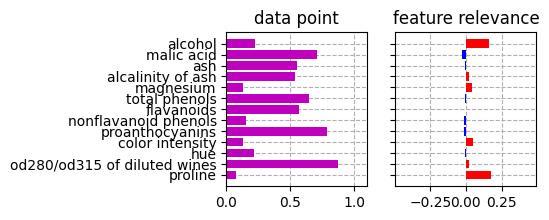

--------------------------------------------------------------------------------
data point 125
  cluster assignment: 1 (probability 0.65)
  true class        : 1
  sum(R) / logit    : 0.6284 / 0.6284


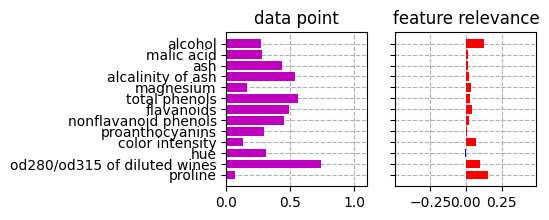

--------------------------------------------------------------------------------
data point 126
  cluster assignment: 1 (probability 0.62)
  true class        : 1
  sum(R) / logit    : 0.4877 / 0.4877


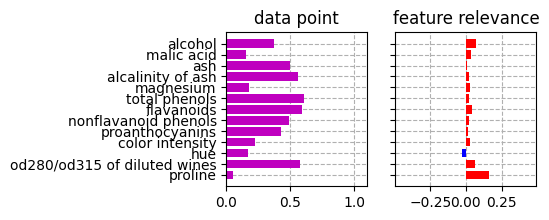

--------------------------------------------------------------------------------
data point 127
  cluster assignment: 1 (probability 0.57)
  true class        : 1
  sum(R) / logit    : 0.2920 / 0.2920


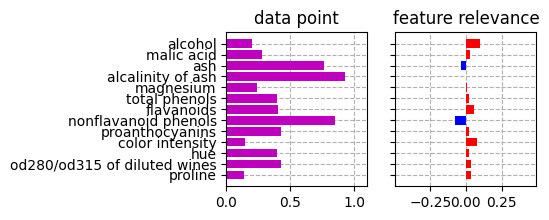

--------------------------------------------------------------------------------
data point 128
  cluster assignment: 1 (probability 0.66)
  true class        : 1
  sum(R) / logit    : 0.6638 / 0.6638


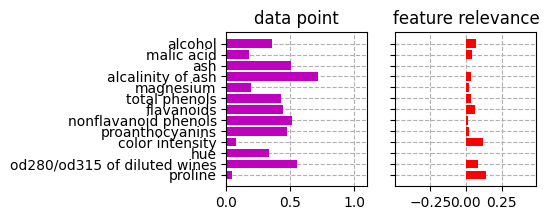

--------------------------------------------------------------------------------
data point 129
  cluster assignment: 1 (probability 0.53)
  true class        : 1
  sum(R) / logit    : 0.1203 / 0.1203


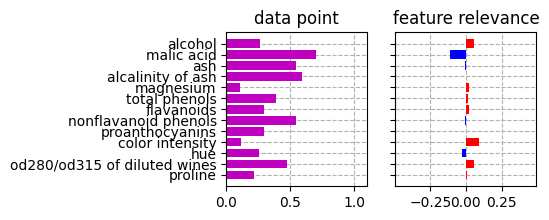

--------------------------------------------------------------------------------
data point 130
  cluster assignment: 2 (probability 0.57)
  true class        : 2
  sum(R) / logit    : 0.2656 / 0.2656


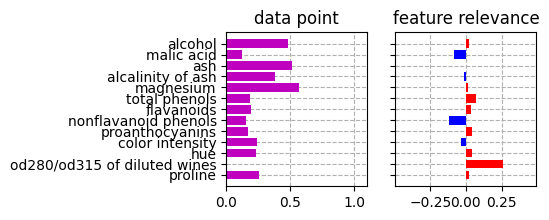

--------------------------------------------------------------------------------
data point 131
  cluster assignment: 2 (probability 0.63)
  true class        : 2
  sum(R) / logit    : 0.5136 / 0.5136


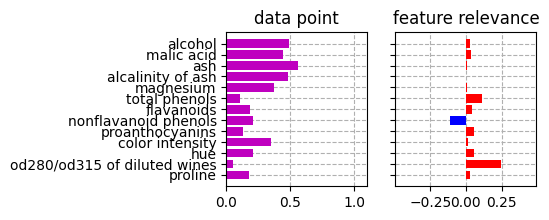

--------------------------------------------------------------------------------
data point 132
  cluster assignment: 2 (probability 0.64)
  true class        : 2
  sum(R) / logit    : 0.5840 / 0.5840


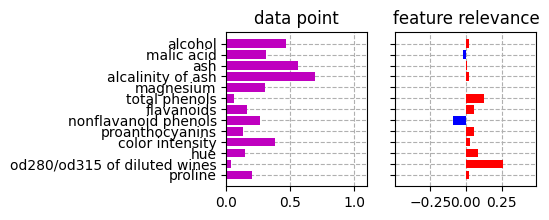

--------------------------------------------------------------------------------
data point 133
  cluster assignment: 2 (probability 0.61)
  true class        : 2
  sum(R) / logit    : 0.4478 / 0.4478


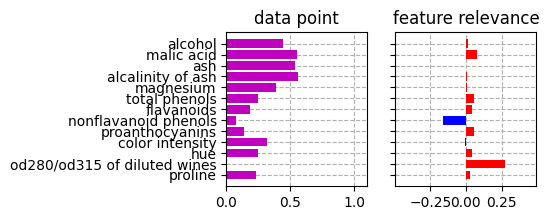

--------------------------------------------------------------------------------
data point 134
  cluster assignment: 2 (probability 0.61)
  true class        : 2
  sum(R) / logit    : 0.4463 / 0.4463


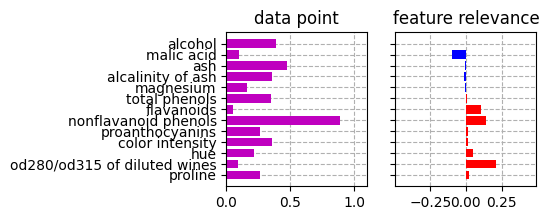

--------------------------------------------------------------------------------
data point 135
  cluster assignment: 2 (probability 0.68)
  true class        : 2
  sum(R) / logit    : 0.7747 / 0.7747


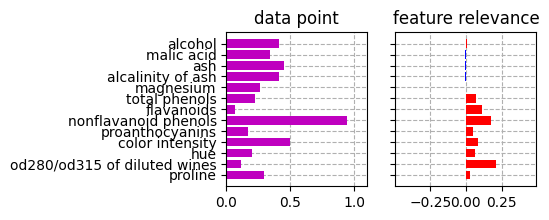

--------------------------------------------------------------------------------
data point 136
  cluster assignment: 2 (probability 0.71)
  true class        : 2
  sum(R) / logit    : 0.8813 / 0.8813


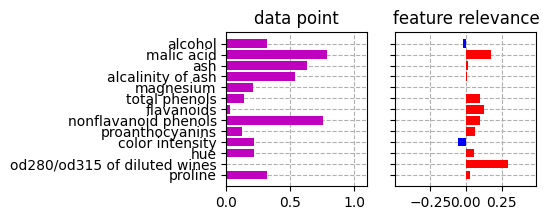

--------------------------------------------------------------------------------
data point 137
  cluster assignment: 2 (probability 0.71)
  true class        : 2
  sum(R) / logit    : 0.8734 / 0.8734


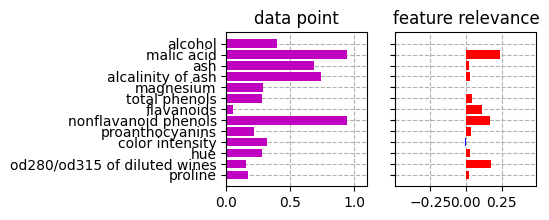

--------------------------------------------------------------------------------
data point 138
  cluster assignment: 2 (probability 0.68)
  true class        : 2
  sum(R) / logit    : 0.7682 / 0.7682


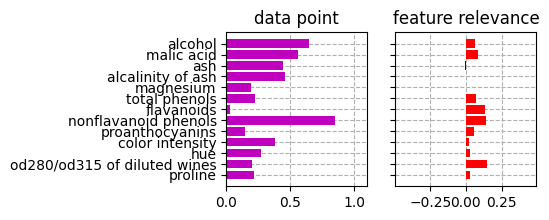

--------------------------------------------------------------------------------
data point 139
  cluster assignment: 2 (probability 0.59)
  true class        : 2
  sum(R) / logit    : 0.3739 / 0.3739


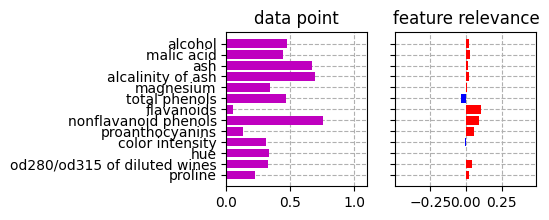

--------------------------------------------------------------------------------
data point 140
  cluster assignment: 2 (probability 0.62)
  true class        : 2
  sum(R) / logit    : 0.4779 / 0.4779


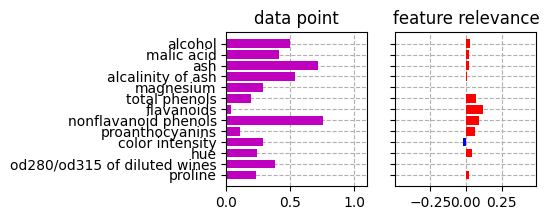

--------------------------------------------------------------------------------
data point 141
  cluster assignment: 2 (probability 0.61)
  true class        : 2
  sum(R) / logit    : 0.4299 / 0.4299


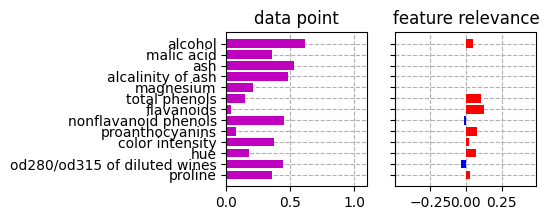

--------------------------------------------------------------------------------
data point 142
  cluster assignment: 2 (probability 0.64)
  true class        : 2
  sum(R) / logit    : 0.5910 / 0.5910


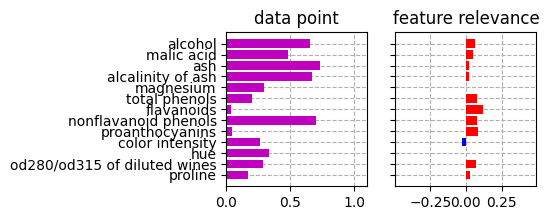

--------------------------------------------------------------------------------
data point 143
  cluster assignment: 2 (probability 0.63)
  true class        : 2
  sum(R) / logit    : 0.5479 / 0.5479


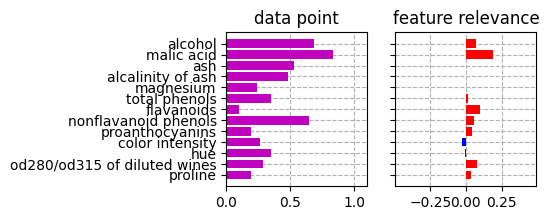

--------------------------------------------------------------------------------
data point 144
  cluster assignment: 2 (probability 0.65)
  true class        : 2
  sum(R) / logit    : 0.6152 / 0.6152


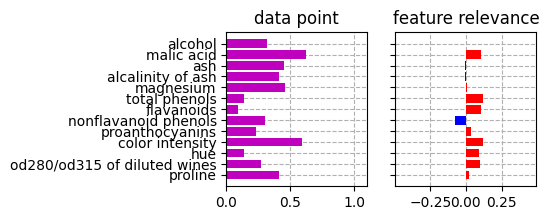

--------------------------------------------------------------------------------
data point 145
  cluster assignment: 2 (probability 0.66)
  true class        : 2
  sum(R) / logit    : 0.6697 / 0.6697


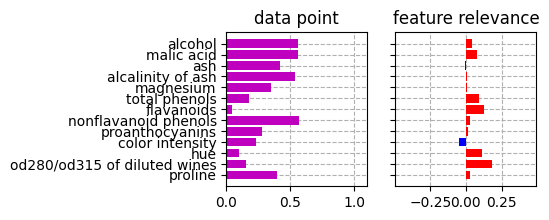

--------------------------------------------------------------------------------
data point 146
  cluster assignment: 2 (probability 0.76)
  true class        : 2
  sum(R) / logit    : 1.1298 / 1.1298


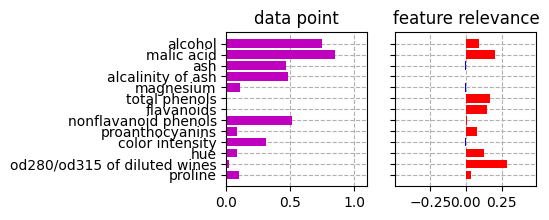

--------------------------------------------------------------------------------
data point 147
  cluster assignment: 2 (probability 0.72)
  true class        : 2
  sum(R) / logit    : 0.9348 / 0.9348


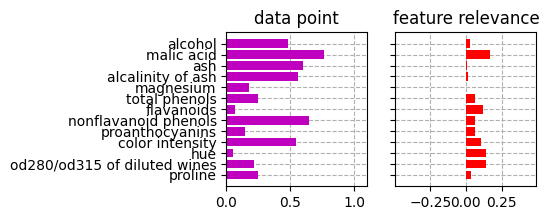

--------------------------------------------------------------------------------
data point 148
  cluster assignment: 2 (probability 0.71)
  true class        : 2
  sum(R) / logit    : 0.8731 / 0.8731


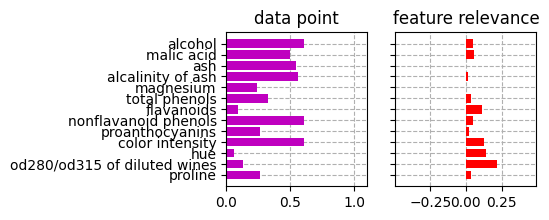

--------------------------------------------------------------------------------
data point 149
  cluster assignment: 2 (probability 0.73)
  true class        : 2
  sum(R) / logit    : 0.9862 / 0.9862


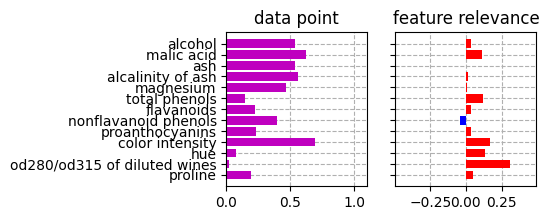

--------------------------------------------------------------------------------
data point 150
  cluster assignment: 2 (probability 0.70)
  true class        : 2
  sum(R) / logit    : 0.8345 / 0.8345


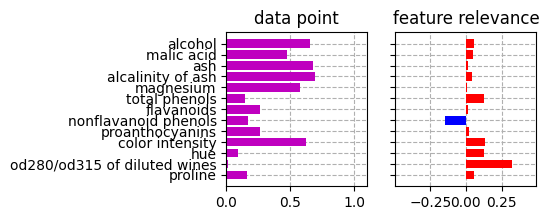

--------------------------------------------------------------------------------
data point 151
  cluster assignment: 2 (probability 0.69)
  true class        : 2
  sum(R) / logit    : 0.8156 / 0.8156


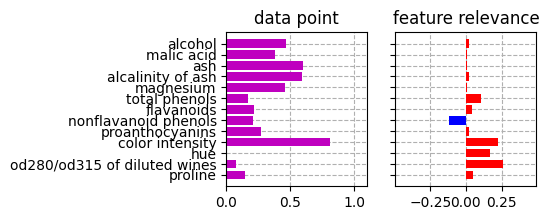

--------------------------------------------------------------------------------
data point 152
  cluster assignment: 2 (probability 0.62)
  true class        : 2
  sum(R) / logit    : 0.4814 / 0.4814


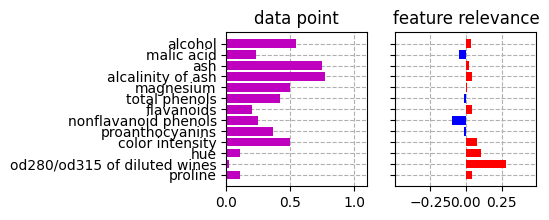

--------------------------------------------------------------------------------
data point 153
  cluster assignment: 2 (probability 0.75)
  true class        : 2
  sum(R) / logit    : 1.0773 / 1.0773


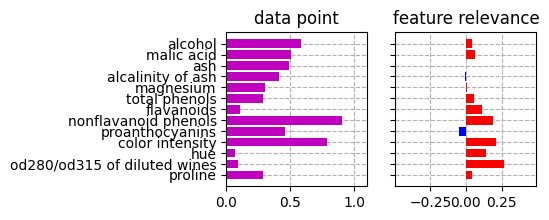

--------------------------------------------------------------------------------
data point 154
  cluster assignment: 2 (probability 0.66)
  true class        : 2
  sum(R) / logit    : 0.6713 / 0.6713


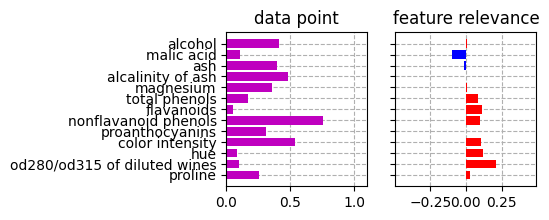

--------------------------------------------------------------------------------
data point 155
  cluster assignment: 2 (probability 0.76)
  true class        : 2
  sum(R) / logit    : 1.1750 / 1.1750


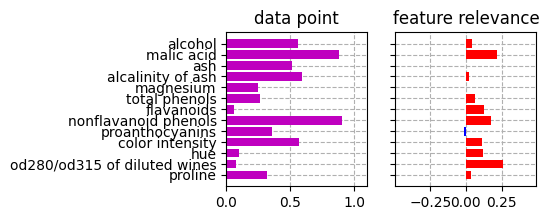

--------------------------------------------------------------------------------
data point 156
  cluster assignment: 2 (probability 0.73)
  true class        : 2
  sum(R) / logit    : 1.0060 / 1.0060


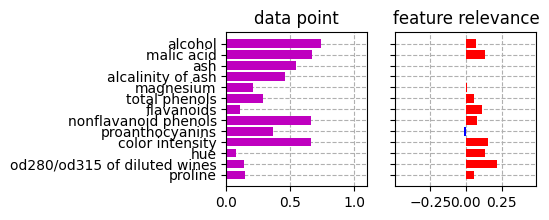

--------------------------------------------------------------------------------
data point 157
  cluster assignment: 2 (probability 0.70)
  true class        : 2
  sum(R) / logit    : 0.8646 / 0.8646


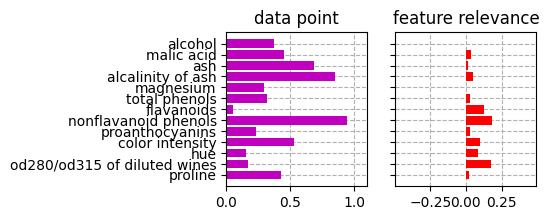

--------------------------------------------------------------------------------
data point 158
  cluster assignment: 2 (probability 0.63)
  true class        : 2
  sum(R) / logit    : 0.5136 / 0.5136


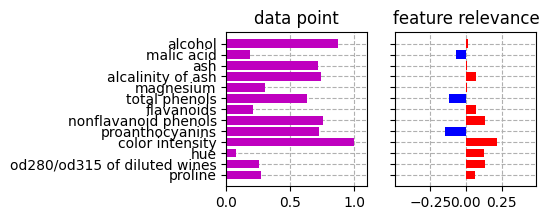

--------------------------------------------------------------------------------
data point 159
  cluster assignment: 2 (probability 0.67)
  true class        : 2
  sum(R) / logit    : 0.7019 / 0.7019


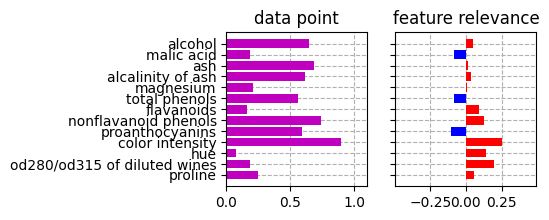

--------------------------------------------------------------------------------
data point 160
  cluster assignment: 2 (probability 0.68)
  true class        : 2
  sum(R) / logit    : 0.7408 / 0.7408


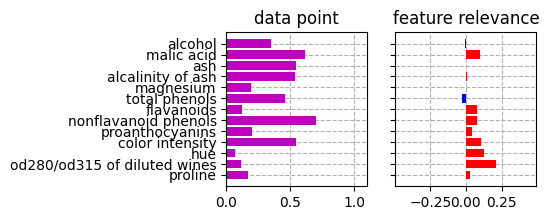

--------------------------------------------------------------------------------
data point 161
  cluster assignment: 2 (probability 0.66)
  true class        : 2
  sum(R) / logit    : 0.6836 / 0.6836


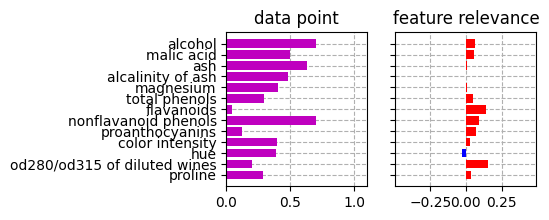

--------------------------------------------------------------------------------
data point 162
  cluster assignment: 2 (probability 0.64)
  true class        : 2
  sum(R) / logit    : 0.5926 / 0.5926


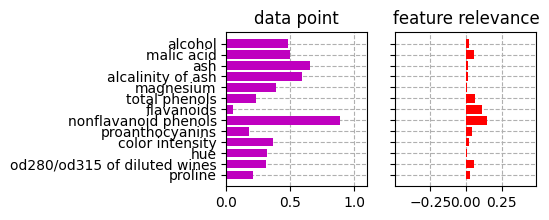

--------------------------------------------------------------------------------
data point 163
  cluster assignment: 2 (probability 0.66)
  true class        : 2
  sum(R) / logit    : 0.6559 / 0.6559


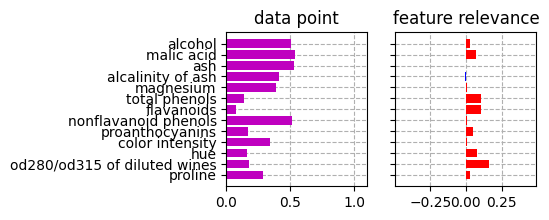

--------------------------------------------------------------------------------
data point 164
  cluster assignment: 2 (probability 0.72)
  true class        : 2
  sum(R) / logit    : 0.9348 / 0.9348


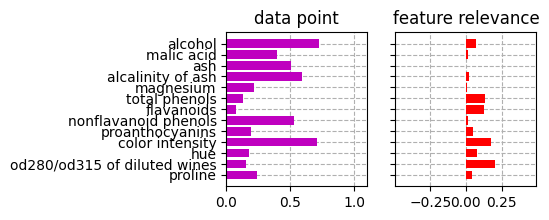

--------------------------------------------------------------------------------
data point 165
  cluster assignment: 2 (probability 0.72)
  true class        : 2
  sum(R) / logit    : 0.9444 / 0.9444


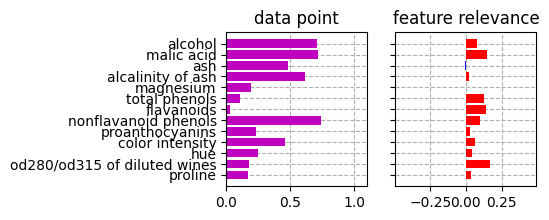

--------------------------------------------------------------------------------
data point 166
  cluster assignment: 2 (probability 0.73)
  true class        : 2
  sum(R) / logit    : 0.9790 / 0.9790


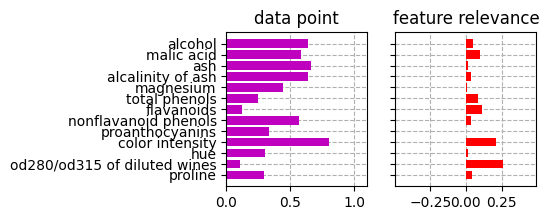

--------------------------------------------------------------------------------
data point 167
  cluster assignment: 2 (probability 0.70)
  true class        : 2
  sum(R) / logit    : 0.8616 / 0.8616


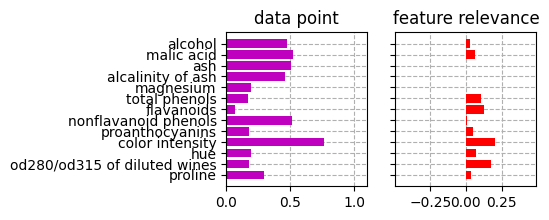

--------------------------------------------------------------------------------
data point 168
  cluster assignment: 2 (probability 0.68)
  true class        : 2
  sum(R) / logit    : 0.7518 / 0.7518


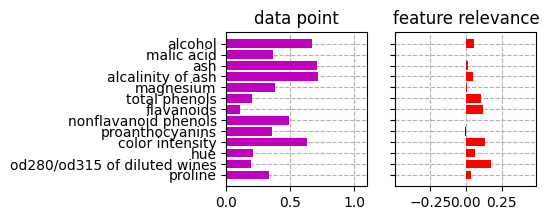

--------------------------------------------------------------------------------
data point 169
  cluster assignment: 2 (probability 0.69)
  true class        : 2
  sum(R) / logit    : 0.7963 / 0.7963


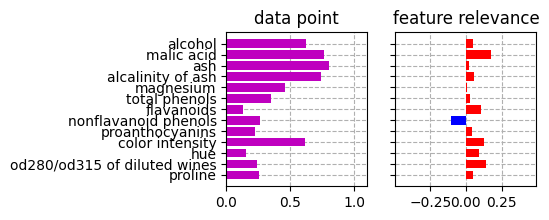

--------------------------------------------------------------------------------
data point 170
  cluster assignment: 2 (probability 0.63)
  true class        : 2
  sum(R) / logit    : 0.5499 / 0.5499


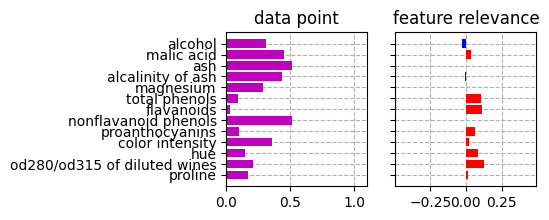

--------------------------------------------------------------------------------
data point 171
  cluster assignment: 2 (probability 0.72)
  true class        : 2
  sum(R) / logit    : 0.9429 / 0.9429


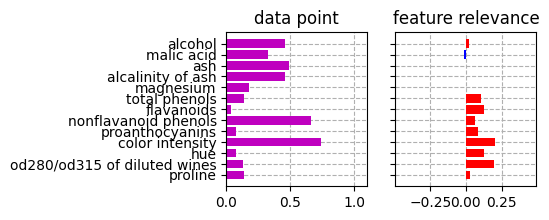

--------------------------------------------------------------------------------
data point 172
  cluster assignment: 2 (probability 0.72)
  true class        : 2
  sum(R) / logit    : 0.9590 / 0.9590


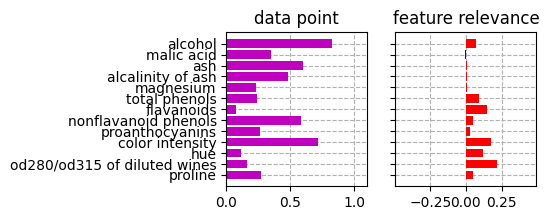

--------------------------------------------------------------------------------
data point 173
  cluster assignment: 2 (probability 0.76)
  true class        : 2
  sum(R) / logit    : 1.1778 / 1.1778


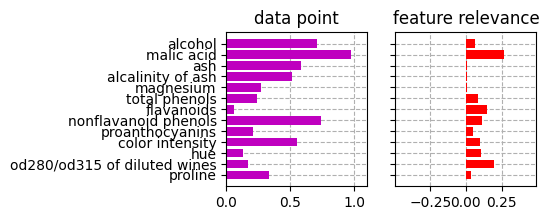

--------------------------------------------------------------------------------
data point 174
  cluster assignment: 2 (probability 0.70)
  true class        : 2
  sum(R) / logit    : 0.8625 / 0.8625


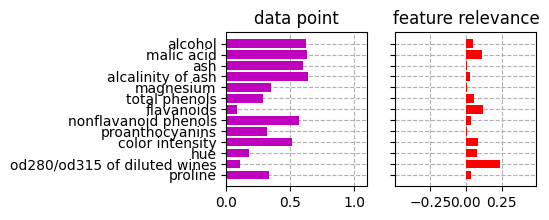

--------------------------------------------------------------------------------
data point 175
  cluster assignment: 2 (probability 0.76)
  true class        : 2
  sum(R) / logit    : 1.1449 / 1.1449


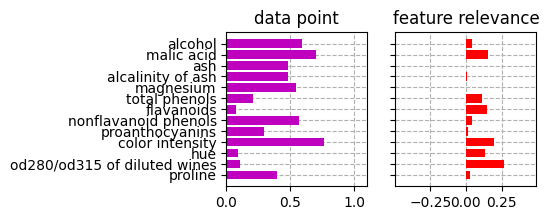

--------------------------------------------------------------------------------
data point 176
  cluster assignment: 2 (probability 0.72)
  true class        : 2
  sum(R) / logit    : 0.9662 / 0.9662


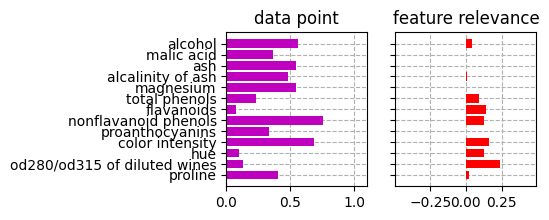

--------------------------------------------------------------------------------
data point 177
  cluster assignment: 2 (probability 0.76)
  true class        : 2
  sum(R) / logit    : 1.1754 / 1.1754


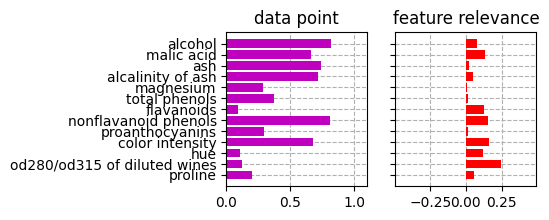

--------------------------------------------------------------------------------


In [ ]:
I = tr.nonzero(y == ytrue)[:,0]
for i in I:
    logit = logits[i]
    prob = 1 / (1 + tr.exp(-logit))
    print('data point %d'%i)
    print('  cluster assignment: %d (probability %.2f)'%(y[i],prob))
    print('  true class        : %d'%ytrue[i])
    print('  sum(R) / logit    : %.4f / %.4f'%(sum(R[i]), logit))
    plot_explanation(X[i], R[i], feature_names, vlim=abs(R[I]).max()*1.1)
    plt.show()
    print('-'*80)

Here, we show an explanation for all misclassified points.

Note that points near the decision boundary (with probability close to 0.5) have low ambiguity regarding the nearest competitors, hence
 as little effect.

data point 60
  cluster assignment: 2 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0772 / 0.0772


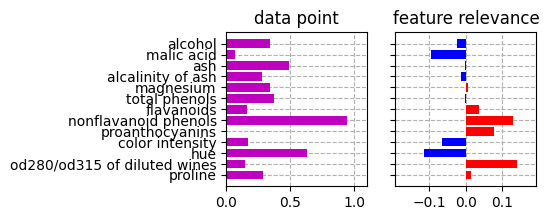

--------------------------------------------------------------------------------
data point 61
  cluster assignment: 2 (probability 0.56)
  true class        : 1
  sum(R) / logit    : 0.2447 / 0.2447


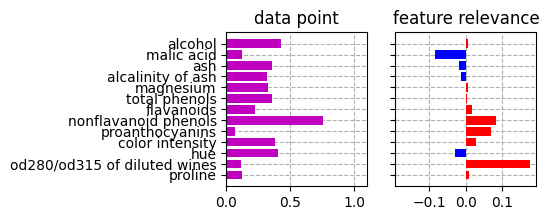

--------------------------------------------------------------------------------
data point 68
  cluster assignment: 2 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0800 / 0.0800


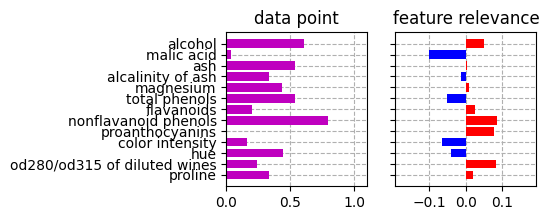

--------------------------------------------------------------------------------
data point 70
  cluster assignment: 2 (probability 0.52)
  true class        : 1
  sum(R) / logit    : 0.0866 / 0.0866


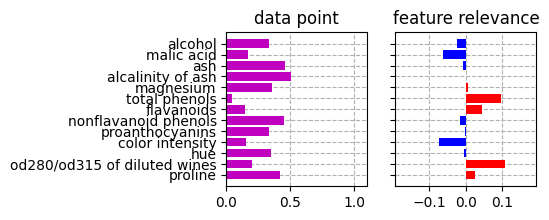

--------------------------------------------------------------------------------
data point 73
  cluster assignment: 0 (probability 0.57)
  true class        : 1
  sum(R) / logit    : 0.2848 / 0.2848


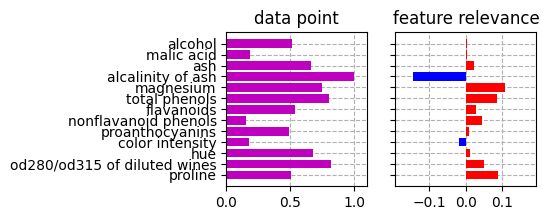

--------------------------------------------------------------------------------
data point 83
  cluster assignment: 2 (probability 0.61)
  true class        : 1
  sum(R) / logit    : 0.4378 / 0.4378


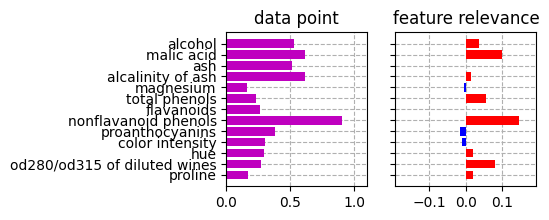

--------------------------------------------------------------------------------
data point 92
  cluster assignment: 2 (probability 0.50)
  true class        : 1
  sum(R) / logit    : 0.0089 / 0.0089


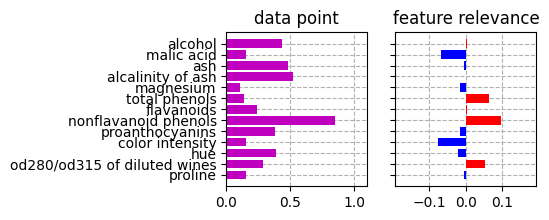

--------------------------------------------------------------------------------
data point 95
  cluster assignment: 0 (probability 0.53)
  true class        : 1
  sum(R) / logit    : 0.1348 / 0.1348


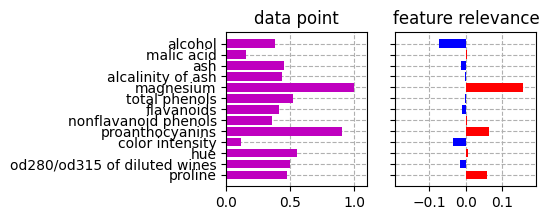

--------------------------------------------------------------------------------
data point 118
  cluster assignment: 2 (probability 0.55)
  true class        : 1
  sum(R) / logit    : 0.2151 / 0.2151


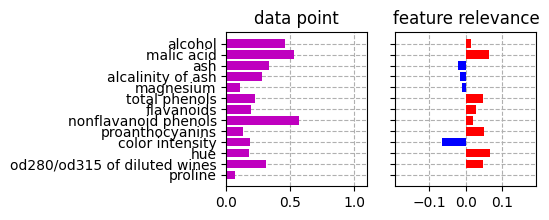

--------------------------------------------------------------------------------


In [ ]:
I = tr.nonzero(y != ytrue)[:,0]
for i in I:
    logit = logits[i]
    prob = 1 / (1 + tr.exp(-logit))

    print('data point %d'%i)
    print('  cluster assignment: %d (probability %.2f)'%(y[i],prob))
    print('  true class        : %d'%ytrue[i])
    print('  sum(R) / logit    : %.4f / %.4f'%(sum(R[i]), logit))
    plot_explanation(X[i], R[i], feature_names, vlim=abs(R[I]).max()*1.1)
    plt.show()
    print('-'*80)